# Backtest
In this section, I will backtest an investment strategy that enters Draftkings DFS contests based on my player statistic projections. I *temporarily* limit the backtest to Draftkings contests due to the current lack of data on the historical results of DFS contests on other sites. The methods that determine which contests I will enter and the lineups that enter each contest will be explored in this notebook. 

## Setup

Import the necessary libraries.

In [1]:
# for data
from pyNBA.Data.constants import ROTO_NAME_TO_NBA_NAME, DB_TEAM_TO_NBA_TEAM, BAD_CONTEST_SUBSTRINGS, OWNERSHIP_NAME_TO_NBA_NAME
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import pandas as pd
import numpy as np
from numpy.random import normal
from datetime import datetime, timedelta

# for models
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site
from pyNBA.Models.fantasy_points import FPModel
from pyNBA.Models.variance import VarianceModel
from pyNBA.Models.ownership import OwnershipModel
from pyNBA.Models.top_score import TopScoreModel
import pulp
from pydfs_lineup_optimizer.solvers.pulp_solver import PuLPSolver

# for backtesting
from pyNBA.Models.features import FeatureCreation
import time
from pydfs_lineup_optimizer import get_optimizer, Sport
from pydfs_lineup_optimizer import Player
from numpy.random import normal
from numpy.random import choice
import scipy.stats as st
import random
from random import sample
from collections import Counter
import bisect

# for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from datetime import datetime
import seaborn as sns; sns.set()

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Data
Collect all data necessary to perform the backtest.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

# historical DFS salary data
salary_data = query_data.query_salary_data()
salary_data = salary_data.rename(columns={'POSITION': 'DFS_POSITION'})
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.roto_name_to_nba_name)

# historical DFS contest data. I am only interested in predicting ownership in Classic GPP compeititions.
contest_data = query_data.query_contest_data()
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[
    (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) & (contest_data['MAXROI'] > 2) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])

# contest payout structure
contest_info = query_data.query_contest_info_data()

# historical player ownership
ownership_data = query_data.query_ownership_data()
ownership_data['NAME'] = ownership_data['PLAYERNAME'].apply(
    lambda x: x if x not in OWNERSHIP_NAME_TO_NBA_NAME else OWNERSHIP_NAME_TO_NBA_NAME[x]
    )

# historical vegas odds data
odds_data = query_data.query_odds_data()

# historical quarterly boxscore data
quarterly_boxscore_data = query_data.query_quarterly_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


## Strategy
Determine viable contests and how to enter each contest.

Initilize data.

In [3]:
season_list = list(boxscores['SEASON'].unique())

# to calculate fantasy points
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)

# isolate Draftkings salaries
boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']
    
# optimize Draftkings NBA lineups
class CustomPuLPSolver(PuLPSolver):
    LP_SOLVER = pulp.GLPK_CMD(msg=0)
optimizer = get_optimizer(Site.DRAFTKINGS, Sport.BASKETBALL, solver=CustomPuLPSolver)

Helper Functions.

In [4]:
def get_contest_prize(contest_info, score):
    prize = contest_info.loc[contest_info['MINPOINTS'] <= score, 'PRIZE'].max()
    return prize

def get_complete_positions(position_list):
    if bool(set(position_list).intersection(['PG', 'SG'])):
        position_list.append('G')
    if bool(set(position_list).intersection(['SF', 'PF'])):
        position_list.append('F')
    position_list.append('U')
    return position_list

def first_valid_position(l1, l2):
    for i in l1:
        if i not in l2:
            return l2 | {i}
        
def get_n_opponent_generations(max_contest_total_entries):
    if max_contest_total_entries < 10000:
        return 3.5
    elif max_contest_total_entries < 50000:
        return 2.5
    elif max_contest_total_entries < 100000:
        return 1.5
    else: 
        return 1
    
def get_prizes(my_scores, opponent_scores, n_opponent_scores, rank_to_prize, entry_fee):
    my_prizes = []

    prev_rank = 0
    for my_score in my_scores:
        if prev_rank == n_opponent_scores:
            my_prizes.append(0 - entry_fee)
        else:
            rank = prev_rank + bisect.bisect_left(opponent_scores[prev_rank:], my_score)
            prize = rank_to_prize[rank+1] if rank+1 in rank_to_prize else 0
            my_prizes.append(prize - entry_fee)
            prev_rank = rank
    
    return my_prizes

Enter contests.

In [5]:
print(time.ctime())

max_entry_fee_per_contest = 1000
max_entry_fee = 250
randomness_factor = 2.5cu
min_salary = 49200
salary_room = 1000
n_opponent_split = 3
max_n_samples = 5
max_player_std = 2
n_simulations = 1500
timeout_minutes = 10

results = pd.DataFrame(columns = [
    'DATE', 'GAME_COUNT', 'CONTEST_TYPE', 'MAX_ENTRIES', 'TOTAL_ENTRIES',
    'ENTRY_FEE', 'CASHLINE', 'SCORE', 'TOP_SCORE', 'PRIZE', 'TOP_PRIZE'
])
pnl = 0

for i in range(1, len(season_list)):
    print(season_list[i])
    fp_train_data = boxscores.loc[boxscores['SEASON'].isin(season_list[0:i])]
    ownership_train_data = boxscores.loc[~(boxscores['SEASON'] == season_list[i])]
    test_data = boxscores.loc[boxscores['SEASON'] == season_list[i]]

    # projected contest top scores
    contest_test_data = contest_data.loc[
        (contest_data['DATE'] >= test_data['DATE'].min()) & (contest_data['DATE'] <= test_data['DATE'].max())
    ]
    contest_train_data = contest_data.loc[
        ~((contest_data['DATE'] >= test_data['DATE'].min()) & (contest_data['DATE'] <= test_data['DATE'].max()))
    ]
    if contest_test_data.empty:
        continue

    # projected fantasy points
    fp_model = FPModel(fp_train_data, test_data, Site.DRAFTKINGS)
    fp_model.train_model(quarterly_boxscore_data, odds_data)
    predictions, fp_hat_column = fp_model.predict()
    predictions = predictions.dropna(subset=[fp_hat_column])

    # actual fantasy points
    predictions['DKFP'] = predictions.apply(
        lambda x: DKFPCalculator.calculate_fantasy_points(
            x['SEASON'], x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']
        ), 
        axis=1
    )

    # fantasy point variance
    variance_model = VarianceModel(predictions)
    predictions, variance_column = variance_model.predict('DKFP')
    pct_variance_column = 'RESIDUAL_PCT'
    predictions[pct_variance_column] = predictions[variance_column]/predictions[fp_hat_column]
    predictions[pct_variance_column] = predictions[pct_variance_column].replace([np.inf, -np.inf], np.nan)
    predictions[pct_variance_column] = predictions[pct_variance_column].fillna(0.35)
    predictions[pct_variance_column] = predictions[pct_variance_column].clip(lower=0.15)

    # projected ownership
    ownership_model = OwnershipModel(ownership_train_data, test_data, Site.DRAFTKINGS)
    ownership_model.create_features(salary_data, contest_data, ownership_data, odds_data)
    ownership_model.train_model()
    ownership_predictions, ownership_column = ownership_model.predict()

    # merge projections to data
    dk_salary_data = salary_data.loc[salary_data['SITE'] == Site.DRAFTKINGS]
    predictions = predictions.merge(dk_salary_data, on=['DATE', 'NAME'], how='left')
    predictions = predictions.dropna(subset=['SALARY', 'DFS_POSITION'])

    ownership_predictions = ownership_predictions.merge(
        predictions[['DATE', 'NAME', fp_hat_column, pct_variance_column, 'SALARY']],
        on=['DATE', 'NAME'], how='left'
    )

    print(time.ctime())

    # iterate through each slate in the season
    a = contest_test_data.loc[contest_test_data['TOTALENTRIES'] <= 250000].sort_values(by='DATE')
    for (date, slate_id), slate_contest_data in a.groupby(['DATE', 'SLATEID']):
        print(time.ctime(), date, slate_id)

        # get players in slate
        slate_teams = slate_contest_data.iloc[0]['TEAMS'].split('_')
        slate_teams = [i if i not in DB_TEAM_TO_NBA_TEAM else DB_TEAM_TO_NBA_TEAM[i] for i in slate_teams]
        board = predictions.loc[
            (predictions['DATE'] == date) &
            (predictions['TEAM'].isin(slate_teams))
        ]

        board_teams = list(board['TEAM'].unique())
        game_count = slate_contest_data.iloc[0]['GAMECOUNT']
        sym_dif = (set(board_teams).symmetric_difference(set(slate_teams)))
        if bool(sym_dif) or len(slate_teams) != game_count*2:
            print('ERROR: MISSING TEAM DATA')
            continue

        slate_ownership_predictions = ownership_predictions.loc[ownership_predictions['SLATEID'] == slate_id]
        slate_board = slate_ownership_predictions[['DATE', 'NAME', ownership_column]].merge(board, on=['DATE', 'NAME'], how='left')
        slate_board = slate_board.dropna(subset=['SALARY', 'DFS_POSITION', fp_hat_column, pct_variance_column, ownership_column])
        ownership_sum = slate_board[ownership_column].sum()
        slate_board[ownership_column] = slate_board[ownership_column].map(lambda x: 8*x/ownership_sum)
            
        # generate opponent lineups for slate
        max_contest_total_entries = slate_contest_data['TOTALENTRIES'].max()
        opponent_players = slate_board.loc[slate_board[ownership_column]*max_contest_total_entries >= 1]
        opponent_players['DFS_POSITIONS'] = opponent_players['DFS_POSITION'].map(lambda x: x.split('_'))
        opponent_players['DFS_POSITIONS'] = opponent_players['DFS_POSITIONS'].map(lambda x: get_complete_positions(x))

        player_counter = Counter()
        max_salary = opponent_players['SALARY'].max()
        n_opponent_generations = get_n_opponent_generations(max_contest_total_entries)
        n_rows = int(max_contest_total_entries/n_opponent_split)
        prev_n_valid_opponent_lineups = 0

        all_opponent_lineups = pd.DataFrame()
        min_lineups = n_opponent_generations*max_contest_total_entries
        end_time = datetime.now() + timedelta(minutes=timeout_minutes)
        while len(all_opponent_lineups) < min_lineups and datetime.now() < end_time:
            opponent_lineups = pd.DataFrame(
                {'PLAYERIDS': np.nan, 'SPOTS_REMAINING': 8, 'POSITIONS_FILLED': np.nan, 'SALARY_REMAINING': 50000},
                index = [i for i in range(n_rows)]
            )
            opponent_lineups['PLAYERIDS'] = [list()] * len(opponent_lineups)
            opponent_lineups['POSITIONS_FILLED'] = [set()] * len(opponent_lineups)
            n_opponent_lineups = len(opponent_lineups)
            
            if prev_n_valid_opponent_lineups == 0:
                opponent_players = opponent_players.sample(frac=1)
            else:
                opponent_players['COUNT'] = opponent_players['PLAYERID'].map(lambda x: player_counter[x])
                opponent_players['EXPECTED_COUNT'] = opponent_players[ownership_column]*len(all_opponent_lineups)
                opponent_players['REP'] = opponent_players['COUNT'] - opponent_players['EXPECTED_COUNT']
                opponent_players = opponent_players.sort_values(by='REP')
            for _, player in opponent_players.iterrows():
                valid_indexes = opponent_lineups.loc[
                    ~(opponent_lineups['POSITIONS_FILLED'].map(set(player['DFS_POSITIONS']).issubset)) &
                    (opponent_lineups['SALARY_REMAINING'] > player['SALARY']) & 
                    (opponent_lineups['SALARY_REMAINING'] - (opponent_lineups['SPOTS_REMAINING']-1)*max_salary - salary_room < player['SALARY'])
                ].index.to_list()
                n = len(valid_indexes)
                len_subset = int(min(n, (n_rows*player[ownership_column])))

                subset = sample(valid_indexes, len_subset)
                opponent_lineups.loc[subset, 'PLAYERIDS'] = opponent_lineups.loc[subset, 'PLAYERIDS'].map(lambda x: x + [player['PLAYERID']])
                opponent_lineups.loc[subset, 'SPOTS_REMAINING'] -= 1
                opponent_lineups.loc[subset, 'POSITIONS_FILLED'] = opponent_lineups.loc[subset, 'POSITIONS_FILLED'].map(
                    lambda x: first_valid_position(player['DFS_POSITIONS'], x)
                )  
                opponent_lineups.loc[subset, 'SALARY_REMAINING'] -= player['SALARY']

            valid_opponent_lineups = opponent_lineups.loc[opponent_lineups['SPOTS_REMAINING'] == 0]
            finished_lineups = valid_opponent_lineups['PLAYERIDS'].to_list()
            for lineup in finished_lineups:
                for player in lineup:
                    player_counter[player] += 1
            
            prev_n_valid_opponent_lineups = len(valid_opponent_lineups)
            all_opponent_lineups = all_opponent_lineups.append(valid_opponent_lineups)
            
        if len(all_opponent_lineups) < min_lineups:
            print('COULD NOT GENERATE {} OPPONENT LINEUPS'.format(min_lineups), time.ctime())
            continue

        print('GENERATED {} OPPONENT LINEUPS'.format(min_lineups), time.ctime())

        # generate potential lineups for slate
        players = []
        for _, player in slate_board.iterrows():
            player_id = player['PLAYERID']
            name = player['NAME'].split()
            first_name = name[0]
            last_name = name[1] if len(name) > 1 else ''
            positions = player['DFS_POSITION'].split('_')
            team = player['TEAM']
            mu = player[fp_hat_column]
            salary =  player['SALARY']
            std = player[pct_variance_column]*(1 - player[ownership_column])

            player = Player(player_id, first_name, last_name, positions, team, salary, mu, standard_deviation=std/randomness_factor)
            players.append(player)

        optimizer.load_players(players)
        optimizer.set_max_deviation(randomness_factor)
        optimizer.set_min_salary_cap(min_salary)

        total_max_entries = slate_contest_data['MAXENTRIES'].sum()
        n = int(max(2.5*total_max_entries, 500))
        lineups = optimizer.optimize(n=n, randomness=True)
        
        potential_lineups = pd.DataFrame()
        try:
            for lineup in lineups:
                player_ids = [i.id for i in lineup.lineup]
                real_score = slate_board.loc[slate_board['PLAYERID'].isin(player_ids), 'DKFP'].sum()
                potential_lineups = potential_lineups.append(
                    pd.DataFrame({'PLAYERIDS': [player_ids], 'REALSCORE': [real_score]})
                )
        except:
            print('ERROR: COULD NOT GENERATE LINEUPS')
            continue
            
        print('GENERATED {} POTENTIAL LINEUPS'.format(n), time.ctime())

        # iterate through each contest in the slate
        slate_contest_data = slate_contest_data.loc[
            (slate_contest_data['ENTRYFEE'] <= max_entry_fee) & (slate_contest_data['ENTRYFEE'] > 1)
        ].sort_values(by='ENTRYFEE', ascending=False)
        for _, contest in slate_contest_data.iterrows():
            contest_id = contest['CONTESTID']
            contest_total_entries = contest['TOTALENTRIES']
            contest_max_entries = contest['MAXENTRIES']
            contest_entry_fee = contest['ENTRYFEE']
            
            result = {} 
            result['DATE'] = date
            result['GAME_COUNT'] = game_count
            result['MAX_ENTRIES'] = contest_max_entries
            result['TOTAL_ENTRIES'] = contest_total_entries
            result['ENTRY_FEE'] = contest_entry_fee
            result['CASHLINE'] = contest['CASHLINE']
            result['TOP_PRIZE'] = contest['TOPPRIZE']
            result['TOP_SCORE'] = contest['TOPSCORE']

            # simulate winnings
            entered_contest_info = contest_info.loc[contest_info['CONTESTID'] == contest_id]
            entered_contest_info['MINPOINTS'] = entered_contest_info['MINPOINTS'].fillna(0)
            rank_to_prize = {}
            prev_i = 0
            prev_prize = 0
            for _, row in entered_contest_info.loc[entered_contest_info['PRIZE'] > 0].iterrows():
                min_rank = int(row['MINRANK'])
                max_rank = int(row['MAXRANK'])
                prize = row['PRIZE']
                for i in range(prev_i+1, min_rank):
                    rank_to_prize[i] = (prize + prev_prize)/2
                for i in range(min_rank, max_rank+1):
                    rank_to_prize[i] = prize
                prev_i = i
                prev_prize = prize

            potential_lineups['WINNINGS'] = 0
            n_samples = int(min(max_n_samples, round(len(all_opponent_lineups)/contest_total_entries)))
            n_simulations_per_sample = int(n_simulations/n_samples)
            for i in range(n_samples):
                opponent_sample = all_opponent_lineups.sample(contest_total_entries)
                for i in range(n_simulations_per_sample):
                    slate_board['SAMPLE'] = slate_board[fp_hat_column]*(1 + normal(0, slate_board[pct_variance_column]))
                    player_performance = slate_board.set_index('PLAYERID')['SAMPLE'].to_dict()

                    opponent_sample['SAMPLE_SCORE'] = opponent_sample['PLAYERIDS'].map(lambda x: -1*sum([player_performance[i] for i in x]))
                    opponent_scores = np.sort(opponent_sample['SAMPLE_SCORE'].to_numpy())[:max_rank]

                    potential_lineups['SAMPLE_SCORE'] = potential_lineups['PLAYERIDS'].map(lambda x: -1*sum([player_performance[i] for i in x]))
                    potential_lineups = potential_lineups.sort_values(by='SAMPLE_SCORE')
                    my_scores = potential_lineups['SAMPLE_SCORE'].to_numpy()

                    prizes = get_prizes(my_scores, opponent_scores, max_rank, rank_to_prize, contest_entry_fee)
                    potential_lineups['WINNINGS'] += prizes

            # enter best lineups
            potential_lineups = potential_lineups.sort_values(by='WINNINGS', ascending=False)
            n_entries = int(min(contest_max_entries, max_entry_fee_per_contest/contest_entry_fee))
            best_lineups = potential_lineups.loc[potential_lineups['WINNINGS'] > 0].head(n_entries)
            n_best_lineups = len(best_lineups)
            potential_lineups = potential_lineups[n_best_lineups:]
            current_pnl = 0
            for _, lineup in best_lineups.iterrows():
                score = lineup['REALSCORE']
                prize = get_contest_prize(entered_contest_info, score)
                
                result['SCORE'] = score
                result['PRIZE'] = prize
                results = results.append(result, ignore_index=True)
                
                contest_pnl = prize - contest_entry_fee
                if not np.isnan(contest_pnl):
                    current_pnl += (prize - contest_entry_fee)

            pnl += current_pnl
            pnl = round(pnl, 2)
            print('{} ({})'.format(str(pnl), str(current_pnl)))

Thu Aug 13 16:14:49 2020
2015-16
2016-17
2017-18
Thu Aug 13 16:59:19 2020
Thu Aug 13 16:59:19 2020 2017-10-18 5ae4d5805689223dfa12d8ad
ERROR: MISSING TEAM DATA
Thu Aug 13 16:59:19 2020 2017-10-18 5ae4dbdb78af173dfeff7c39
ERROR: MISSING TEAM DATA
Thu Aug 13 16:59:19 2020 2017-10-18 5ae4e8b05689223dfa4d3bd7
ERROR: MISSING TEAM DATA
Thu Aug 13 16:59:19 2020 2017-10-19 5ae4d09dc074cf3dff3e3d91
ERROR: MISSING TEAM DATA
Thu Aug 13 16:59:19 2020 2017-10-19 5ae515ee589eaa73373fe802
ERROR: MISSING TEAM DATA
Thu Aug 13 16:59:19 2020 2017-10-20 5ae4cbe2c074cf3dff32fa1b
GENERATED 95365.0 OPPONENT LINEUPS Thu Aug 13 17:01:37 2020
GENERATED 400 POTENTIAL LINEUPS Thu Aug 13 17:02:11 2020
350.0 (350.0)
6755.0 (6405.0)
6796.0 (41.0)
Thu Aug 13 17:03:16 2020 2017-10-20 5ae4d5895689223dfa12e192
GENERATED 118905.0 OPPONENT LINEUPS Thu Aug 13 17:07:01 2020
GENERATED 522 POTENTIAL LINEUPS Thu Aug 13 17:07:41 2020
6346.0 (-450.0)
6046.0 (-300.0)
5946.0 (-100.0)
5796.0 (-150.0)
5756.0 (-40.0)
5729.0 (-27.0)
5

GENERATED 118905.0 OPPONENT LINEUPS Thu Aug 13 19:01:07 2020
GENERATED 966 POTENTIAL LINEUPS Thu Aug 13 19:02:43 2020
4180.72 (200.0)
4380.72 (200.0)
4245.72 (-135.0)
4305.72 (60.0)
4325.72 (20.0)
4333.72 (8.0)
4341.72 (8.0)
4372.72 (31.0)
4323.72 (-49.0)
4611.72 (288.0)
4494.72 (-117.0)
Thu Aug 13 19:05:31 2020 2017-10-29 5ae51523589eaa73373d82a0
GENERATED 25732.0 OPPONENT LINEUPS Thu Aug 13 19:06:51 2020
GENERATED 400 POTENTIAL LINEUPS Thu Aug 13 19:07:14 2020
4855.72 (361.0)
4668.72 (-187.0)
3964.72 (-704.0)
Thu Aug 13 19:07:41 2020 2017-10-29 5ae6045cfd67640e26f38b1c
GENERATED 25732.0 OPPONENT LINEUPS Thu Aug 13 19:08:48 2020
GENERATED 400 POTENTIAL LINEUPS Thu Aug 13 19:09:10 2020
9986.72 (6022.0)
Thu Aug 13 19:09:26 2020 2017-10-30 5ae4c91ff69c5a3e00128218
GENERATED 118905.0 OPPONENT LINEUPS Thu Aug 13 19:12:28 2020
GENERATED 1210 POTENTIAL LINEUPS Thu Aug 13 19:15:02 2020
9536.72 (-450.0)
9086.72 (-450.0)
8986.72 (-100.0)
8836.72 (-150.0)
8836.72 (0.0)
8796.72 (-40.0)
8756.72 (-

19558.22 (-922.0)
19382.22 (-176.0)
19308.66 (-73.56)
19228.66 (-80.0)
Thu Aug 13 20:41:03 2020 2017-11-08 5ae4cc0c0f94ac3e01808d1a
GENERATED 118905.0 OPPONENT LINEUPS Thu Aug 13 20:43:29 2020
GENERATED 838 POTENTIAL LINEUPS Thu Aug 13 20:44:40 2020
19378.66 (150.0)
19228.66 (-150.0)
19128.66 (-100.0)
18978.66 (-150.0)
18938.66 (-40.0)
18058.66 (-880.0)
17715.66 (-343.0)
17517.66 (-198.0)
17490.66 (-27.0)
17465.66 (-25.0)
17445.66 (-20.0)
17433.66 (-12.0)
17303.66 (-130.0)
16566.66 (-737.0)
16561.66 (-5.0)
16549.66 (-12.0)
16501.66 (-48.0)
16451.66 (-50.0)
16446.66 (-5.0)
16398.66 (-48.0)
16396.66 (-2.0)
Thu Aug 13 20:47:21 2020 2017-11-08 5ae4f1bfd69dcc3dfd279719
GENERATED 55145.0 OPPONENT LINEUPS Thu Aug 13 20:48:32 2020
GENERATED 582 POTENTIAL LINEUPS Thu Aug 13 20:49:12 2020
16172.66 (-224.0)
15746.26 (-426.4)
15342.62 (-403.64)
15268.62 (-74.0)
Thu Aug 13 20:50:08 2020 2017-11-09 5ae4c92e0f94ac3e017aba25
GENERATED 20807.5 OPPONENT LINEUPS Thu Aug 13 20:51:05 2020
GENERATED 400 POT

38163.78 (-2.0)
Thu Aug 13 22:16:18 2020 2017-11-18 5ae4e3c7f69c5a3e004a4976
GENERATED 45955.0 OPPONENT LINEUPS Thu Aug 13 22:17:56 2020
GENERATED 492 POTENTIAL LINEUPS Thu Aug 13 22:18:25 2020
37929.78 (-234.0)
37660.78 (-269.0)
36915.01 (-745.77)
36849.01 (-66.0)
Thu Aug 13 22:19:12 2020 2017-11-19 5ae4cd6edd71203dfc438848
GENERATED 36762.5 OPPONENT LINEUPS Thu Aug 13 22:20:08 2020
GENERATED 400 POTENTIAL LINEUPS Thu Aug 13 22:20:27 2020
36902.01 (53.0)
36594.54 (-307.47)
Thu Aug 13 22:20:56 2020 2017-11-19 5ae4e628d69dcc3dfd0c50b2
GENERATED 36162.5 OPPONENT LINEUPS Thu Aug 13 22:21:39 2020
GENERATED 400 POTENTIAL LINEUPS Thu Aug 13 22:22:01 2020
37459.54 (865.0)
37832.18 (372.64)
38150.18 (318.0)
Thu Aug 13 22:22:37 2020 2017-11-19 5ae4e62c5689223dfa43cfa9
GENERATED 80832.5 OPPONENT LINEUPS Thu Aug 13 22:24:19 2020
GENERATED 502 POTENTIAL LINEUPS Thu Aug 13 22:24:50 2020
37950.18 (-200.0)
37570.18 (-380.0)
37558.18 (-12.0)
37758.58 (200.39999999999998)
37738.58 (-20.0)
Thu Aug 13 22

34720.01 (-27.0)
34685.01 (-35.0)
34743.01 (58.0)
34753.01 (10.0)
34741.01 (-12.0)
34743.01 (2.0)
35829.01 (1086.0)
35827.01 (-2.0)
Fri Aug 14 00:16:07 2020 2017-12-01 5ae4d5d978af173dfef1afb4
GENERATED 36762.5 OPPONENT LINEUPS Fri Aug 14 00:16:51 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 00:17:16 2020
36205.01 (378.0)
36016.01 (-189.0)
Fri Aug 14 00:17:45 2020 2017-12-02 5ae4c952d69dcc3dfdd35950
GENERATED 77205.0 OPPONENT LINEUPS Fri Aug 14 00:19:07 2020
GENERATED 1110 POTENTIAL LINEUPS Fri Aug 14 00:20:57 2020
35816.01 (-200.0)
35666.01 (-150.0)
35716.01 (50.0)
35268.01 (-448.0)
35298.01 (30.0)
35033.01 (-265.0)
35111.01 (78.0)
35036.01 (-75.0)
35024.01 (-12.0)
34609.93 (-414.08)
34222.93 (-387.0)
34217.93 (-5.0)
34225.93 (8.0)
34217.93 (-8.0)
34245.93 (28.0)
34242.93 (-3.0)
Fri Aug 14 00:25:00 2020 2017-12-02 5ae4cc580f94ac3e0180e043
GENERATED 36762.5 OPPONENT LINEUPS Fri Aug 14 00:26:24 2020
GENERATED 858 POTENTIAL LINEUPS Fri Aug 14 00:27:27 2020
34077.93 (-165.0)
33863.93 (

GENERATED 118905.0 OPPONENT LINEUPS Fri Aug 14 02:11:18 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 02:11:48 2020
53985.39 (-900.0)
53535.39 (-450.0)
53235.39 (-300.0)
53135.39 (-100.0)
53095.39 (-40.0)
52720.39 (-375.0)
52693.39 (-27.0)
52618.39 (-75.0)
52606.39 (-12.0)
52612.39 (6.0)
52361.39 (-251.0)
52356.39 (-5.0)
52344.39 (-12.0)
52297.39 (-47.0)
52253.39 (-44.0)
Fri Aug 14 02:13:13 2020 2017-12-13 5ae4cad0c074cf3dff314d7e
GENERATED 51470.0 OPPONENT LINEUPS Fri Aug 14 02:14:36 2020
GENERATED 444 POTENTIAL LINEUPS Fri Aug 14 02:14:58 2020
52288.39 (35.0)
52151.39 (-137.0)
51735.33 (-416.06)
51675.33 (-60.0)
Fri Aug 14 02:15:46 2020 2017-12-13 5b834df0dc114c2ea02f5d80
GENERATED 5145.0 OPPONENT LINEUPS Fri Aug 14 02:16:11 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 02:16:29 2020
51568.33 (-107.0)
Fri Aug 14 02:16:35 2020 2017-12-14 5ae4c96c0f94ac3e017b55b2
GENERATED 80260.5 OPPONENT LINEUPS Fri Aug 14 02:18:13 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 02:18:36 2020
514

GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 03:56:52 2020
62413.05 (-249.92000000000002)
Fri Aug 14 03:57:07 2020 2017-12-25 5ae4cf505689223dfa03aa34
GENERATED 45955.0 OPPONENT LINEUPS Fri Aug 14 03:58:40 2020
GENERATED 588 POTENTIAL LINEUPS Fri Aug 14 03:59:19 2020
62088.05 (-325.0)
61642.05 (-446.0)
61451.3 (-190.75)
61453.97 (2.6700000000000017)
Fri Aug 14 04:00:11 2020 2017-12-25 5ae50f6eb819ea73344e5e1b
GENERATED 25732.0 OPPONENT LINEUPS Fri Aug 14 04:01:28 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 04:01:50 2020
60970.4 (-483.57)
60809.4 (-161.0)
Fri Aug 14 04:02:10 2020 2017-12-26 5ae4cae7c074cf3dff315b32
GENERATED 118905.0 OPPONENT LINEUPS Fri Aug 14 04:05:36 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 04:06:04 2020
60509.4 (-300.0)
60409.4 (-100.0)
60369.4 (-40.0)
60009.4 (-360.0)
59910.4 (-99.0)
59883.4 (-27.0)
59871.4 (-12.0)
59859.4 (-12.0)
59854.4 (-5.0)
59842.4 (-12.0)
59804.4 (-38.0)
59744.4 (-60.0)
Fri Aug 14 04:07:13 2020 2017-12-26 5ae5f8ef5641740e23440b16
GEN

GENERATED 448 POTENTIAL LINEUPS Fri Aug 14 05:45:19 2020
321082.85 (-330.0)
320422.85 (-660.0)
320362.85 (-60.0)
320350.85 (-12.0)
Fri Aug 14 05:46:24 2020 2018-01-05 5ae4b0800f94ac3e01338f73
GENERATED 88234.5 OPPONENT LINEUPS Fri Aug 14 05:48:18 2020
GENERATED 932 POTENTIAL LINEUPS Fri Aug 14 05:50:03 2020
319900.85 (-450.0)
319800.85 (-100.0)
318892.85 (-908.0)
318188.85 (-704.0)
318148.85 (-40.0)
318049.85 (-99.0)
318022.85 (-27.0)
318010.85 (-12.0)
317169.85 (-841.0)
317164.85 (-5.0)
317152.85 (-12.0)
317092.85 (-60.0)
317042.85 (-50.0)
Fri Aug 14 05:54:13 2020 2018-01-06 5ae4aac5c074cf3dffdc9dfa
GENERATED 29725.0 OPPONENT LINEUPS Fri Aug 14 05:54:57 2020
GENERATED 404 POTENTIAL LINEUPS Fri Aug 14 05:55:20 2020
316712.85 (-330.0)
316725.85 (13.0)
316010.85 (-715.0)
315976.85 (-34.0)
Fri Aug 14 05:56:05 2020 2018-01-06 5ae4b648c074cf3dfffdc38e
GENERATED 36762.5 OPPONENT LINEUPS Fri Aug 14 05:57:16 2020
GENERATED 414 POTENTIAL LINEUPS Fri Aug 14 05:57:36 2020
315811.85 (-165.0)
31625

360201.45 (-165.0)
359745.89 (-455.56)
359886.89 (141.0)
359851.89 (-35.0)
Fri Aug 14 07:35:41 2020 2018-01-15 5ae4afdd5689223dfab608ec
GENERATED 99087.5 OPPONENT LINEUPS Fri Aug 14 07:38:30 2020
GENERATED 1638 POTENTIAL LINEUPS Fri Aug 14 07:41:50 2020
359801.89 (-50.0)
359501.89 (-300.0)
359201.89 (-300.0)
358751.89 (-450.0)
358651.89 (-100.0)
358611.89 (-40.0)
358571.89 (-40.0)
357581.89 (-990.0)
356987.89 (-594.0)
356960.89 (-27.0)
356900.89 (-60.0)
356888.89 (-12.0)
356876.89 (-12.0)
356864.89 (-12.0)
356044.89 (-820.0)
355190.89 (-854.0)
354537.75 (-653.14)
354104.75 (-433.0)
354099.75 (-5.0)
354067.75 (-32.0)
354029.75 (-38.0)
353974.75 (-55.0)
353936.75 (-38.0)
Fri Aug 14 07:47:01 2020 2018-01-15 5ae4b83dc074cf3dff030cab
GENERATED 20807.5 OPPONENT LINEUPS Fri Aug 14 07:52:45 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 07:53:06 2020
353913.75 (-23.0)
Fri Aug 14 07:53:13 2020 2018-01-15 5ae4b9f895356d3dfb0b9d65
GENERATED 36762.5 OPPONENT LINEUPS Fri Aug 14 07:54:02 2020
GENER

368064.66 (7.0)
368060.66 (-4.0)
Fri Aug 14 09:36:39 2020 2018-01-23 5ae4b8600f94ac3e014d6c72
GENERATED 73312.5 OPPONENT LINEUPS Fri Aug 14 09:40:02 2020
GENERATED 454 POTENTIAL LINEUPS Fri Aug 14 09:40:33 2020
367715.66 (-345.0)
367703.66 (-12.0)
367181.66 (-522.0)
367107.66 (-74.0)
Fri Aug 14 09:42:33 2020 2018-01-23 5ae4c69678af173dfecd01fb
GENERATED 24969.0 OPPONENT LINEUPS Fri Aug 14 09:44:48 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 09:45:14 2020
367776.32 (668.66)
Fri Aug 14 09:45:23 2020 2018-01-24 5ae4ae2f0f94ac3e012c417a
GENERATED 118905.0 OPPONENT LINEUPS Fri Aug 14 09:48:58 2020
GENERATED 1252 POTENTIAL LINEUPS Fri Aug 14 09:53:30 2020
378626.32 (10850.0)
378526.32 (-100.0)
378709.57 (183.25)
378739.57 (30.0)
378640.57 (-99.0)
378613.57 (-27.0)
378586.57 (-27.0)
378796.57 (210.0)
378809.57 (13.0)
378797.57 (-12.0)
379022.57 (225.0)
380826.57 (1804.0)
380880.24 (53.67)
380875.24 (-5.0)
380857.24 (-18.0)
380829.24 (-28.0)
380857.24 (28.0)
380848.24 (-9.0)
380847.57 (-0.

GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 12:09:23 2020
446708.33 (858.0)
Fri Aug 14 12:09:30 2020 2018-02-02 5ae4b16bc074cf3dffeef2ca
GENERATED 45955.0 OPPONENT LINEUPS Fri Aug 14 12:11:52 2020
GENERATED 462 POTENTIAL LINEUPS Fri Aug 14 12:12:20 2020
446923.33 (215.0)
446920.33 (-3.0)
446446.0 (-474.33)
446406.0 (-40.0)
Fri Aug 14 12:13:13 2020 2018-02-02 5aff6353bb77ff4c53c73b1d
GENERATED 89179.5 OPPONENT LINEUPS Fri Aug 14 12:15:46 2020
GENERATED 1010 POTENTIAL LINEUPS Fri Aug 14 12:17:58 2020
445956.0 (-450.0)
445806.0 (-150.0)
445706.0 (-100.0)
444738.0 (-968.0)
444698.0 (-40.0)
444599.0 (-99.0)
444659.5 (60.5)
444750.41 (90.90999999999997)
444738.41 (-12.0)
444726.41 (-12.0)
449701.41 (4975.0)
449696.41 (-5.0)
449622.41 (-74.0)
449572.41 (-50.0)
449563.41 (-9.0)
449519.41 (-44.0)
Fri Aug 14 12:22:41 2020 2018-02-03 5ae4abc25689223dfaa9aeef
GENERATED 51470.0 OPPONENT LINEUPS Fri Aug 14 12:23:50 2020
GENERATED 414 POTENTIAL LINEUPS Fri Aug 14 12:24:20 2020
449414.41 (-105.0)
44940

442322.24 (-2.0)
442325.24 (3.0)
442299.24 (-26.0)
Fri Aug 14 14:53:44 2020 2018-02-13 5ae4c11f0f94ac3e01633b92
GENERATED 52407.5 OPPONENT LINEUPS Fri Aug 14 14:57:01 2020
GENERATED 408 POTENTIAL LINEUPS Fri Aug 14 14:57:19 2020
443590.74 (1291.5)
443598.74 (8.0)
443698.95 (100.21000000000001)
443744.95 (46.0)
Fri Aug 14 14:58:03 2020 2018-02-14 5ae4abd3d69dcc3dfd80b88f
GENERATED 107014.5 OPPONENT LINEUPS Fri Aug 14 15:00:30 2020
GENERATED 1258 POTENTIAL LINEUPS Fri Aug 14 15:03:11 2020
442888.95 (-856.0)
442688.95 (-200.0)
442588.95 (-100.0)
441946.95 (-642.0)
440946.95 (-1000.0)
441006.95 (60.0)
440907.95 (-99.0)
440880.95 (-27.0)
440346.55 (-534.3999999999996)
440746.55 (400.0)
440734.55 (-12.0)
440722.55 (-12.0)
440346.55 (-376.0)
440341.55 (-5.0)
440506.55 (165.0)
440470.55 (-36.0)
440491.55 (21.0)
440482.55 (-9.0)
440471.21 (-11.340000000000007)
Fri Aug 14 15:08:06 2020 2018-02-14 5ae4b495dd71203dfc034a96
GENERATED 55970.0 OPPONENT LINEUPS Fri Aug 14 15:09:37 2020
GENERATED 408 P

517042.03 (-300.0)
517842.03 (800.0)
517882.03 (40.0)
517848.03 (-34.0)
517946.03 (98.0)
518303.53 (357.5)
518291.53 (-12.0)
518472.53 (181.0)
518792.36 (319.83000000000004)
518787.36 (-5.0)
518761.36 (-26.0)
518761.56 (0.1999999999999993)
518798.06 (36.5)
Fri Aug 14 17:02:59 2020 2018-03-02 5ae4b272f69c5a3e00cd4427
GENERATED 5145.0 OPPONENT LINEUPS Fri Aug 14 17:03:15 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 17:03:32 2020
519875.06 (1077.0)
Fri Aug 14 17:03:38 2020 2018-03-02 5ae4c2e5dd71203dfc2937f0
GENERATED 51470.0 OPPONENT LINEUPS Fri Aug 14 17:04:24 2020
GENERATED 502 POTENTIAL LINEUPS Fri Aug 14 17:04:48 2020
519380.06 (-495.0)
519368.06 (-12.0)
518428.06 (-940.0)
518182.06 (-246.0)
518118.06 (-64.0)
Fri Aug 14 17:05:39 2020 2018-03-03 5ae4ab2978af173dfe6fd81e
GENERATED 107014.5 OPPONENT LINEUPS Fri Aug 14 17:07:07 2020
GENERATED 946 POTENTIAL LINEUPS Fri Aug 14 17:08:31 2020
517918.06 (-200.0)
517197.06 (-721.0)
517297.06 (100.0)
517345.31 (48.25)
517305.31 (-40.0)
51750

GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 18:42:32 2020
548762.6 (-842.0)
Fri Aug 14 18:42:45 2020 2018-03-12 5ae4ab30c074cf3dffde2176
GENERATED 118906 OPPONENT LINEUPS Fri Aug 14 18:44:49 2020
GENERATED 1000 POTENTIAL LINEUPS Fri Aug 14 18:46:09 2020
548974.6 (212.0)
548574.6 (-400.0)
548624.6 (50.0)
548324.6 (-300.0)
548284.6 (-40.0)
548096.6 (-188.0)
547990.35 (-106.25)
547963.35 (-27.0)
547936.35 (-27.0)
547916.35 (-20.0)
547904.35 (-12.0)
547778.35 (-126.0)
547582.35 (-196.0)
547165.35 (-417.0)
547160.35 (-5.0)
547115.35 (-45.0)
547117.35 (2.0)
Fri Aug 14 18:50:44 2020 2018-03-13 5ae4ac3a95356d3dfbde5339
GENERATED 132352.5 OPPONENT LINEUPS Fri Aug 14 18:53:18 2020
GENERATED 1064 POTENTIAL LINEUPS Fri Aug 14 18:55:15 2020
546579.35 (-538.0)
546429.35 (-150.0)
546329.35 (-100.0)
546289.35 (-40.0)
546190.35 (-99.0)
546163.35 (-27.0)
545283.35 (-880.0)
545289.35 (6.0)
544642.83 (-646.52)
544637.83 (-5.0)
544642.83 (5.0)
544642.83 (0.0)
544602.83 (-40.0)
Fri Aug 14 18:59:23 2020 2018-

577570.31 (610.0)
578010.31 (440.0)
579060.59 (1050.28)
579277.09 (216.5)
579377.09 (100.0)
Fri Aug 14 20:22:39 2020 2018-03-23 5ae4aa82dd71203dfcdddf9c
GENERATED 133768.5 OPPONENT LINEUPS Fri Aug 14 20:25:01 2020
GENERATED 1142 POTENTIAL LINEUPS Fri Aug 14 20:27:03 2020
579177.09 (-200.0)
580527.09 (1350.0)
580427.09 (-100.0)
580327.09 (-100.0)
580172.09 (-155.0)
579367.09 (-805.0)
579327.09 (-40.0)
579357.09 (30.0)
579258.09 (-99.0)
579271.09 (13.0)
579244.09 (-27.0)
579252.09 (8.0)
579260.09 (8.0)
579227.09 (-33.0)
578950.59 (-276.5)
578680.59 (-270.0)
578695.59 (15.0)
578655.59 (-40.0)
Fri Aug 14 20:30:57 2020 2018-03-23 5ae4b2bbf69c5a3e00ce3a02
GENERATED 47057.5 OPPONENT LINEUPS Fri Aug 14 20:32:14 2020
GENERATED 458 POTENTIAL LINEUPS Fri Aug 14 20:32:38 2020
578255.59 (-400.0)
577760.59 (-495.0)
576760.59 (-1000.0)
576599.59 (-161.0)
576519.59 (-80.0)
Fri Aug 14 20:33:28 2020 2018-03-23 5ae4b67e0f94ac3e014751d6
GENERATED 20807.5 OPPONENT LINEUPS Fri Aug 14 20:34:04 2020
GENERATED

738028.45 (-182.0)
737906.45 (-122.0)
737309.45 (-597.0)
736428.45 (-881.0)
Fri Aug 14 21:54:32 2020 2018-04-03 5ae4ae65d69dcc3dfd894c41
GENERATED 36762.5 OPPONENT LINEUPS Fri Aug 14 21:55:45 2020
GENERATED 532 POTENTIAL LINEUPS Fri Aug 14 21:56:11 2020
739457.45 (3029.0)
742951.33 (3493.88)
747046.7 (4095.37)
Fri Aug 14 21:56:48 2020 2018-04-03 5ae4ae665689223dfab25ae1
GENERATED 89177.5 OPPONENT LINEUPS Fri Aug 14 21:58:17 2020
GENERATED 904 POTENTIAL LINEUPS Fri Aug 14 21:59:57 2020
746158.7 (-888.0)
746308.7 (150.0)
746158.7 (-150.0)
746118.7 (-40.0)
746078.7 (-40.0)
745198.7 (-880.0)
745211.7 (13.0)
745651.7 (440.0)
745621.7 (-30.0)
745273.7 (-348.0)
745268.7 (-5.0)
745209.43 (-59.269999999999996)
745200.43 (-9.0)
Fri Aug 14 22:02:08 2020 2018-04-03 5ae4c680dd71203dfc33235d
GENERATED 2572.5 OPPONENT LINEUPS Fri Aug 14 22:02:25 2020
GENERATED 400 POTENTIAL LINEUPS Fri Aug 14 22:02:41 2020
745024.43 (-176.0)
Fri Aug 14 22:02:45 2020 2018-04-03 5ae4c76ff69c5a3e000e21ac
GENERATED 2572.

GENERATED 44120.0 OPPONENT LINEUPS Sat Aug 15 00:07:06 2020
GENERATED 526 POTENTIAL LINEUPS Sat Aug 15 00:07:34 2020
740131.14 (-540.0)
741083.14 (952.0)
740996.45 (-86.69)
742071.45 (1075.0)
742121.78 (50.33)
Sat Aug 15 00:08:19 2020 2018-10-20 5bd2034e07a90936d12c310b
GENERATED 20811.0 OPPONENT LINEUPS Sat Aug 15 00:09:21 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 00:09:39 2020
742440.95 (319.17)
Sat Aug 15 00:09:48 2020 2018-10-21 5bcd09fd503b872185a18338
GENERATED 91575.0 OPPONENT LINEUPS Sat Aug 15 00:12:15 2020
GENERATED 520 POTENTIAL LINEUPS Sat Aug 15 00:12:42 2020
741552.95 (-888.0)
741252.95 (-300.0)
741152.95 (-100.0)
741112.95 (-40.0)
740332.95 (-780.0)
740272.95 (-60.0)
740260.95 (-12.0)
739521.67 (-739.28)
739517.67 (-4.0)
739484.67 (-33.0)
Sat Aug 15 00:14:29 2020 2018-10-21 5bcd40bd2ed87b218b835395
GENERATED 34092.5 OPPONENT LINEUPS Sat Aug 15 00:15:37 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 00:15:56 2020
738664.67 (-820.0)
738625.67 (-39.0)
Sat Aug 15 00:1

GENERATED 1664 POTENTIAL LINEUPS Sat Aug 15 01:53:52 2020
711073.19 (400.0)
711523.19 (450.0)
711423.19 (-100.0)
711573.19 (150.0)
711839.19 (266.0)
711161.19 (-678.0)
711221.19 (60.0)
711181.19 (-40.0)
711236.19 (55.0)
711242.19 (6.0)
711265.19 (23.0)
711253.19 (-12.0)
711136.76 (-116.43)
711201.76 (65.0)
711201.76 (0.0)
711201.76 (0.0)
711189.76 (-12.0)
711205.76 (16.0)
711227.88 (22.12)
711229.88 (2.0)
Sat Aug 15 01:58:47 2020 2018-10-31 5bdafd1d5d569553ee52f0ef
GENERATED 73530.0 OPPONENT LINEUPS Sat Aug 15 02:00:40 2020
GENERATED 500 POTENTIAL LINEUPS Sat Aug 15 02:01:05 2020
711049.88 (-180.0)
710449.88 (-600.0)
710103.88 (-346.0)
710091.88 (-12.0)
709338.82 (-753.06)
709298.82 (-40.0)
709283.82 (-15.0)
Sat Aug 15 02:02:17 2020 2018-10-31 5bdafd285d569553ee53254e
GENERATED 10297.0 OPPONENT LINEUPS Sat Aug 15 02:02:51 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 02:03:09 2020
708878.57 (-405.25)
Sat Aug 15 02:03:17 2020 2018-11-01 5bdb85dffc020153e9c3e894
GENERATED 93751.5 OPPON

712616.8 (-75.0)
711648.8 (-968.0)
711608.8 (-40.0)
711548.8 (-60.0)
710708.8 (-840.0)
710696.8 (-12.0)
710064.8 (-632.0)
709562.26 (-502.54)
709550.26 (-12.0)
709502.26 (-48.0)
709457.26 (-45.0)
709455.26 (-2.0)
Sat Aug 15 03:35:41 2020 2018-11-09 5be6e0aae6da7d2781e176c4
GENERATED 20811.0 OPPONENT LINEUPS Sat Aug 15 03:36:30 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 03:36:47 2020
708765.26 (-690.0)
708710.26 (-55.0)
Sat Aug 15 03:37:01 2020 2018-11-09 5be6e0bb201054277c0bcdc3
GENERATED 44120.0 OPPONENT LINEUPS Sat Aug 15 03:37:36 2020
GENERATED 474 POTENTIAL LINEUPS Sat Aug 15 03:37:58 2020
707990.26 (-720.0)
707826.26 (-164.0)
707746.26 (-80.0)
706866.26 (-880.0)
706892.09 (25.83)
Sat Aug 15 03:38:43 2020 2018-11-10 5be7730d201054277c0e21fd
GENERATED 77206.5 OPPONENT LINEUPS Sat Aug 15 03:40:21 2020
GENERATED 1178 POTENTIAL LINEUPS Sat Aug 15 03:42:18 2020
706442.09 (-450.0)
706342.09 (-100.0)
706117.09 (-225.0)
705967.09 (-150.0)
704999.09 (-968.0)
704959.09 (-40.0)
704919.09

GENERATED 1400 POTENTIAL LINEUPS Sat Aug 15 05:10:50 2020
703942.99 (-600.0)
704042.99 (100.0)
703817.99 (-225.0)
703742.99 (-75.0)
702844.99 (-898.0)
702804.99 (-40.0)
702834.99 (30.0)
702822.99 (-12.0)
702207.99 (-615.0)
702202.99 (-5.0)
702197.99 (-5.0)
702197.99 (0.0)
702173.55 (-24.44)
702171.55 (-2.0)
Sat Aug 15 05:14:18 2020 2018-11-19 5bf3dfb040060d7286f2fd6a
GENERATED 29134.0 OPPONENT LINEUPS Sat Aug 15 05:15:14 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 05:15:32 2020
702021.55 (-150.0)
701176.55 (-845.0)
Sat Aug 15 05:15:48 2020 2018-11-20 5bf4a08340060d7286f944b4
GENERATED 85612.5 OPPONENT LINEUPS Sat Aug 15 05:17:22 2020
GENERATED 1302 POTENTIAL LINEUPS Sat Aug 15 05:19:21 2020
701476.55 (300.0)
701376.55 (-100.0)
700476.55 (-900.0)
700776.55 (300.0)
700676.55 (-100.0)
701176.55 (500.0)
701251.55 (75.0)
701211.55 (-40.0)
701271.55 (60.0)
700999.05 (-272.5)
700939.05 (-60.0)
700947.05 (8.0)
700935.05 (-12.0)
703901.3 (2966.25)
703591.3 (-310.0)
703594.3 (3.0)
703597.3 (

758880.29 (-8.77)
Sat Aug 15 06:45:19 2020 2018-11-28 5c01408ebc10e95e214ce4fb
GENERATED 24972.5 OPPONENT LINEUPS Sat Aug 15 06:46:13 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 06:46:33 2020
758040.29 (-840.0)
Sat Aug 15 06:46:42 2020 2018-11-29 5c008bf2bc10e95e2137ca5e
GENERATED 85612.5 OPPONENT LINEUPS Sat Aug 15 06:48:17 2020
GENERATED 1162 POTENTIAL LINEUPS Sat Aug 15 06:49:49 2020
757152.29 (-888.0)
756552.29 (-600.0)
756452.29 (-100.0)
756177.29 (-275.0)
755275.29 (-902.0)
755235.29 (-40.0)
755175.29 (-60.0)
754210.29 (-965.0)
754198.29 (-12.0)
753394.29 (-804.0)
753389.29 (-5.0)
753321.29 (-68.0)
753241.29 (-80.0)
753232.29 (-9.0)
753230.29 (-2.0)
Sat Aug 15 06:52:45 2020 2018-11-29 5c013f9abc10e95e21467792
GENERATED 42067.5 OPPONENT LINEUPS Sat Aug 15 06:54:04 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 06:54:20 2020
752690.29 (-540.0)
752492.29 (-198.0)
751887.29 (-605.0)
751842.29 (-45.0)
Sat Aug 15 06:54:57 2020 2018-11-30 5c01cf7ebc10e95e2150e85a
GENERATED 85612.5 

740362.92 (33.0)
Sat Aug 15 08:19:10 2020 2018-12-09 5c0e3af965e8df7d24db917e
GENERATED 20811.0 OPPONENT LINEUPS Sat Aug 15 08:19:42 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 08:19:59 2020
740097.92 (-265.0)
739572.92 (-525.0)
Sat Aug 15 08:20:14 2020 2018-12-10 5b4611a2f65cbc506e678180
GENERATED 85612.5 OPPONENT LINEUPS Sat Aug 15 08:21:50 2020
GENERATED 1244 POTENTIAL LINEUPS Sat Aug 15 08:24:09 2020
738972.92 (-600.0)
738672.92 (-300.0)
738572.92 (-100.0)
738297.92 (-275.0)
737499.92 (-798.0)
737459.92 (-40.0)
737432.92 (-27.0)
737422.92 (-10.0)
737410.92 (-12.0)
737398.92 (-12.0)
736778.92 (-620.0)
735968.92 (-810.0)
735798.92 (-170.0)
735793.92 (-5.0)
735746.92 (-47.0)
735715.92 (-31.0)
735713.92 (-2.0)
735711.92 (-2.0)
Sat Aug 15 08:27:59 2020 2018-12-10 5c0f8bddf8e7e63b27b09c93
GENERATED 44590.0 OPPONENT LINEUPS Sat Aug 15 08:28:55 2020
GENERATED 500 POTENTIAL LINEUPS Sat Aug 15 08:29:18 2020
735171.92 (-540.0)
735006.92 (-165.0)
734591.92 (-415.0)
733726.92 (-865.0)
73367

777483.87 (-40.0)
777318.87 (-165.0)
777291.87 (-27.0)
777231.87 (-60.0)
777219.87 (-12.0)
777247.87 (28.0)
776576.87 (-671.0)
775981.87 (-595.0)
775667.87 (-314.0)
775551.87 (-116.0)
775554.87 (3.0)
775557.53 (2.66)
775547.58 (-9.95)
775546.58 (-1.0)
775544.58 (-2.0)
Sat Aug 15 09:50:14 2020 2018-12-19 5c1b1282d55e075fc1935618
GENERATED 59455.0 OPPONENT LINEUPS Sat Aug 15 09:51:38 2020
GENERATED 410 POTENTIAL LINEUPS Sat Aug 15 09:51:57 2020
776324.58 (780.0)
776474.58 (150.0)
776983.58 (509.0)
776971.58 (-12.0)
777016.58 (45.0)
Sat Aug 15 09:52:47 2020 2018-12-19 5c1b6a39d55e075fc1973a0f
GENERATED 29134.0 OPPONENT LINEUPS Sat Aug 15 09:53:59 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 09:54:17 2020
776892.58 (-124.0)
776946.58 (54.0)
Sat Aug 15 09:54:32 2020 2018-12-20 5b461fe5b45617545163020d
GENERATED 125444 OPPONENT LINEUPS Sat Aug 15 09:57:31 2020
GENERATED 848 POTENTIAL LINEUPS Sat Aug 15 09:58:25 2020
776546.58 (-400.0)
775646.58 (-900.0)
775546.58 (-100.0)
775396.58 (-150.

813286.64 (-12.0)
812686.64 (-600.0)
812681.64 (-5.0)
812676.64 (-5.0)
812596.64 (-80.0)
812584.64 (-12.0)
812570.64 (-14.0)
812568.64 (-2.0)
Sat Aug 15 11:24:30 2020 2018-12-28 5c277abee9cbeb4dfac18c41
GENERATED 24972.5 OPPONENT LINEUPS Sat Aug 15 11:25:15 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 11:25:33 2020
812478.64 (-90.0)
812498.64 (20.0)
Sat Aug 15 11:25:48 2020 2018-12-28 5c277ac737cda83f8f47aa85
GENERATED 37160.0 OPPONENT LINEUPS Sat Aug 15 11:26:44 2020
GENERATED 430 POTENTIAL LINEUPS Sat Aug 15 11:27:04 2020
812138.64 (-360.0)
811973.64 (-165.0)
811961.64 (-12.0)
811336.64 (-625.0)
811271.64 (-65.0)
811231.64 (-40.0)
Sat Aug 15 11:27:44 2020 2018-12-29 5c280bca37cda83f8f4a4974
GENERATED 85612.5 OPPONENT LINEUPS Sat Aug 15 11:28:55 2020
GENERATED 1044 POTENTIAL LINEUPS Sat Aug 15 11:30:35 2020
810631.64 (-600.0)
810531.64 (-100.0)
810306.64 (-225.0)
810156.64 (-150.0)
809533.64 (-623.0)
809493.64 (-40.0)
809466.64 (-27.0)
809436.64 (-30.0)
809424.64 (-12.0)
809319.64 

GENERATED 93305.0 OPPONENT LINEUPS Sat Aug 15 12:50:59 2020
GENERATED 808 POTENTIAL LINEUPS Sat Aug 15 12:51:53 2020
787395.6 (-600.0)
787295.6 (-100.0)
787145.6 (-150.0)
786527.6 (-618.0)
786487.6 (-40.0)
786460.6 (-27.0)
786400.6 (-60.0)
786388.6 (-12.0)
785628.6 (-760.0)
785623.6 (-5.0)
785569.6 (-54.0)
785560.6 (-9.0)
Sat Aug 15 12:53:41 2020 2019-01-06 5c332d6747efe743bb4eb745
GENERATED 20590.5 OPPONENT LINEUPS Sat Aug 15 12:54:13 2020
GENERATED 460 POTENTIAL LINEUPS Sat Aug 15 12:54:35 2020
785650.6 (90.0)
785875.6 (225.0)
785730.6 (-145.0)
785743.6 (13.0)
785761.35 (17.75)
Sat Aug 15 12:55:08 2020 2019-01-07 5bfe34c451fc266970fc1e59
GENERATED 29134.0 OPPONENT LINEUPS Sat Aug 15 12:56:11 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 12:56:30 2020
785749.35 (-12.0)
786329.85 (580.5)
786309.85 (-20.0)
Sat Aug 15 12:56:49 2020 2019-01-07 5c33e88eb1699a43c052edfe
GENERATED 89181.0 OPPONENT LINEUPS Sat Aug 15 12:58:11 2020
GENERATED 1310 POTENTIAL LINEUPS Sat Aug 15 13:00:31 2020
78

758083.31 (-12.0)
757859.15 (-224.16000000000003)
757855.97 (-3.1799999999999997)
Sat Aug 15 14:15:54 2020 2019-01-14 5c3f48cd51ff69211dc63bab
GENERATED 20811.0 OPPONENT LINEUPS Sat Aug 15 14:16:36 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 14:16:54 2020
757365.97 (-490.0)
Sat Aug 15 14:17:02 2020 2019-01-15 5c3f498751ff69211dcab19d
GENERATED 89181.0 OPPONENT LINEUPS Sat Aug 15 14:18:54 2020
GENERATED 1352 POTENTIAL LINEUPS Sat Aug 15 14:21:12 2020
756477.97 (-888.0)
756177.97 (-300.0)
756227.97 (50.0)
756002.97 (-225.0)
755952.97 (-50.0)
755894.97 (-58.0)
755526.97 (-368.0)
755486.97 (-40.0)
755499.97 (13.0)
755439.97 (-60.0)
755254.97 (-185.0)
754374.97 (-880.0)
754362.97 (-12.0)
754415.97 (53.0)
753851.97 (-564.0)
753729.97 (-122.0)
753732.97 (3.0)
753668.97 (-64.0)
753630.97 (-38.0)
753634.97 (4.0)
753632.97 (-2.0)
Sat Aug 15 14:25:05 2020 2019-01-15 5c3f4a18a2a33021752735f0
GENERATED 29134.0 OPPONENT LINEUPS Sat Aug 15 14:25:55 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 

759538.01 (-150.0)
759013.01 (-525.0)
759016.01 (3.0)
758996.01 (-20.0)
758997.01 (1.0)
758993.01 (-4.0)
758994.01 (1.0)
Sat Aug 15 15:48:10 2020 2019-01-23 5c49913ba2a3302175c0d57d
GENERATED 29727.5 OPPONENT LINEUPS Sat Aug 15 15:48:40 2020
GENERATED 420 POTENTIAL LINEUPS Sat Aug 15 15:49:01 2020
758934.01 (-60.0)
758957.01 (23.0)
759147.01 (190.0)
759248.48 (101.47)
759320.81 (72.33)
Sat Aug 15 15:49:33 2020 2019-01-24 5c4a5ff9a2a3302175cb75c5
GENERATED 89181.0 OPPONENT LINEUPS Sat Aug 15 15:51:33 2020
GENERATED 1538 POTENTIAL LINEUPS Sat Aug 15 15:54:11 2020
760632.81 (1312.0)
760432.81 (-200.0)
760072.81 (-360.0)
759972.81 (-100.0)
759922.81 (-50.0)
759772.81 (-150.0)
759738.48 (-34.329999999999984)
759824.48 (86.0)
759784.48 (-40.0)
759744.48 (-40.0)
759717.48 (-27.0)
759690.48 (-27.0)
759670.48 (-20.0)
759658.48 (-12.0)
759691.48 (33.0)
759651.48 (-40.0)
759301.48 (-350.0)
759328.62 (27.14)
758895.58 (-433.03999999999996)
758898.58 (3.0)
758965.08 (66.5)
758964.08 (-1.0)
758977.0

733790.16 (-481.0)
733210.88 (-579.28)
733217.88 (7.0)
732977.11 (-240.76999999999998)
732947.11 (-30.0)
732949.31 (2.2)
732940.31 (-9.0)
732938.31 (-2.0)
Sat Aug 15 17:48:59 2020 2019-02-01 5c5516dae14fcc57edd88286
GENERATED 42982.5 OPPONENT LINEUPS Sat Aug 15 17:50:06 2020
GENERATED 402 POTENTIAL LINEUPS Sat Aug 15 17:50:25 2020
732698.31 (-240.0)
734125.31 (1427.0)
734113.31 (-12.0)
734142.57 (29.260000000000005)
734199.16 (56.59)
Sat Aug 15 17:51:03 2020 2019-02-01 5c558d21d8e8c957f228baa9
GENERATED 28766.5 OPPONENT LINEUPS Sat Aug 15 17:51:51 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 17:52:08 2020
734783.54 (584.38)
734807.32 (23.78)
Sat Aug 15 17:52:22 2020 2019-02-02 5c563d3be14fcc57ede1fb48
GENERATED 85612.5 OPPONENT LINEUPS Sat Aug 15 17:53:56 2020
GENERATED 1830 POTENTIAL LINEUPS Sat Aug 15 17:58:20 2020
734447.32 (-360.0)
734347.32 (-100.0)
734247.32 (-100.0)
734097.32 (-150.0)
733947.32 (-150.0)
733145.32 (-802.0)
732837.32 (-308.0)
732797.32 (-40.0)
732770.32 (-27.0)

GENERATED 118907.5 OPPONENT LINEUPS Sat Aug 15 19:46:19 2020
GENERATED 1510 POTENTIAL LINEUPS Sat Aug 15 19:48:40 2020
832746.28 (-888.0)
832346.28 (-400.0)
832246.28 (-100.0)
831648.28 (-598.0)
831608.28 (-40.0)
831581.28 (-27.0)
831521.28 (-60.0)
831266.28 (-255.0)
831181.28 (-85.0)
831169.28 (-12.0)
830889.28 (-280.0)
830884.28 (-5.0)
830639.14 (-245.14)
830613.14 (-26.0)
830604.14 (-9.0)
830602.14 (-2.0)
Sat Aug 15 19:51:38 2020 2019-02-10 5c61470949fc2b6cdd63d3a7
GENERATED 89180.0 OPPONENT LINEUPS Sat Aug 15 19:54:24 2020
GENERATED 622 POTENTIAL LINEUPS Sat Aug 15 19:54:58 2020
830422.14 (-180.0)
830522.14 (100.0)
830722.14 (200.0)
830557.47 (-164.67)
830672.47 (115.0)
830702.47 (30.0)
830232.47 (-470.0)
830020.06 (-212.41)
830033.06 (13.0)
830041.06 (8.0)
830046.06 (5.0)
830048.06 (2.0)
830003.06 (-45.0)
Sat Aug 15 19:56:34 2020 2019-02-10 5c61474149fc2b6cdd653ecf
GENERATED 29727.5 OPPONENT LINEUPS Sat Aug 15 19:56:58 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 19:57:14 2020


GENERATED 29412.5 OPPONENT LINEUPS Sat Aug 15 21:39:18 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 21:39:34 2020
799193.44 (-915.0)
Sat Aug 15 21:39:52 2020 2019-02-25 5c7481f8ebb2d45b2af4b8ae
GENERATED 147060.0 OPPONENT LINEUPS Sat Aug 15 21:42:13 2020
GENERATED 2170 POTENTIAL LINEUPS Sat Aug 15 21:47:59 2020
799093.44 (-100.0)
798493.44 (-600.0)
798393.44 (-100.0)
798293.44 (-100.0)
797293.44 (-1000.0)
797343.44 (50.0)
797193.44 (-150.0)
796885.44 (-308.0)
795997.44 (-888.0)
795957.44 (-40.0)
795930.44 (-27.0)
795870.44 (-60.0)
795075.44 (-795.0)
795063.44 (-12.0)
795076.44 (13.0)
794207.44 (-869.0)
793986.85 (-220.59)
793812.85 (-174.0)
793807.85 (-5.0)
793802.85 (-5.0)
793796.85 (-6.0)
793754.85 (-42.0)
793752.85 (-2.0)
Sat Aug 15 21:54:14 2020 2019-02-25 5c750fe8ebb2d45b2a048ed0
GENERATED 37160.0 OPPONENT LINEUPS Sat Aug 15 21:54:55 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 21:55:15 2020
793392.85 (-360.0)
792853.52 (-539.3299999999999)
792820.52 (-33.0)
Sat Aug 15 21:55

796497.83 (-755.0)
796403.83 (-94.0)
795709.83 (-694.0)
795272.97 (-436.86)
795277.97 (5.0)
795272.97 (-5.0)
795219.72 (-53.25)
795184.72 (-35.0)
795175.72 (-9.0)
795173.72 (-2.0)
Sat Aug 15 23:42:38 2020 2019-03-05 5c7fa17215afa8650c7bc955
GENERATED 44590.0 OPPONENT LINEUPS Sat Aug 15 23:43:35 2020
GENERATED 400 POTENTIAL LINEUPS Sat Aug 15 23:43:53 2020
795333.72 (160.0)
795768.72 (435.0)
795233.72 (-535.0)
795201.72 (-32.0)
Sat Aug 15 23:44:25 2020 2019-03-06 5c805f9f15afa8650c83842e
GENERATED 89181.0 OPPONENT LINEUPS Sat Aug 15 23:46:14 2020
GENERATED 2060 POTENTIAL LINEUPS Sat Aug 15 23:51:20 2020
794601.72 (-600.0)
793601.72 (-1000.0)
793513.72 (-88.0)
793363.72 (-150.0)
793213.72 (-150.0)
792325.72 (-888.0)
792285.72 (-40.0)
792258.72 (-27.0)
792198.72 (-60.0)
791332.72 (-866.0)
791320.72 (-12.0)
790555.55 (-765.17)
790550.55 (-5.0)
789898.55 (-652.0)
789818.55 (-80.0)
789809.55 (-9.0)
789807.55 (-2.0)
Sat Aug 15 23:55:42 2020 2019-03-06 5c80f2ea15afa8650c85c3dc
GENERATED 59455.

GENERATED 1530 POTENTIAL LINEUPS Sun Aug 16 01:36:42 2020
811517.82 (800.0)
811617.82 (100.0)
811467.82 (-150.0)
810674.82 (-793.0)
810634.82 (-40.0)
810607.82 (-27.0)
810687.82 (80.0)
811327.82 (640.0)
811355.82 (28.0)
811707.82 (352.0)
811296.49 (-411.33)
811291.49 (-5.0)
811297.49 (6.0)
811283.69 (-13.800000000000008)
811274.69 (-9.0)
811272.69 (-2.0)
Sun Aug 16 01:40:15 2020 2019-03-14 5c8b70b5b5ff6b6507cde56a
GENERATED 10297.0 OPPONENT LINEUPS Sun Aug 16 01:40:39 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 01:40:55 2020
811225.69 (-47.0)
Sun Aug 16 01:41:03 2020 2019-03-14 5c8b70bab5ff6b6507cdf874
GENERATED 44590.0 OPPONENT LINEUPS Sun Aug 16 01:42:04 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 01:42:21 2020
810685.69 (-540.0)
810520.69 (-165.0)
809710.69 (-810.0)
809698.69 (-12.0)
Sun Aug 16 01:42:49 2020 2019-03-15 5bf711c19e72870c068a3bef
GENERATED 85612.5 OPPONENT LINEUPS Sun Aug 16 01:44:32 2020
GENERATED 1888 POTENTIAL LINEUPS Sun Aug 16 01:49:00 2020
809198.69 (-500

GENERATED 74317.5 OPPONENT LINEUPS Sun Aug 16 03:13:28 2020
GENERATED 1256 POTENTIAL LINEUPS Sun Aug 16 03:15:18 2020
801428.3 (-400.0)
801328.3 (-100.0)
800974.3 (-354.0)
800934.3 (-40.0)
801094.3 (160.0)
801054.3 (-40.0)
800539.3 (-515.0)
800502.63 (-36.67)
800515.63 (13.0)
800523.63 (8.0)
800526.63 (3.0)
800521.63 (-5.0)
800507.49 (-14.14)
800577.49 (70.0)
800582.49 (5.0)
Sun Aug 16 03:17:24 2020 2019-03-24 5c993c37c92a4620592d9803
GENERATED 59455.0 OPPONENT LINEUPS Sun Aug 16 03:18:35 2020
GENERATED 574 POTENTIAL LINEUPS Sun Aug 16 03:19:05 2020
799682.49 (-900.0)
799582.49 (-100.0)
799364.49 (-218.0)
799324.49 (-40.0)
798824.49 (-500.0)
798414.49 (-410.0)
798505.82 (91.33)
798500.82 (-5.0)
798503.82 (3.0)
798479.82 (-24.0)
Sun Aug 16 03:20:10 2020 2019-03-24 5c993c3994d552663ac2256b
GENERATED 29727.5 OPPONENT LINEUPS Sun Aug 16 03:21:02 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 03:21:20 2020
799420.09 (940.27)
799543.26 (123.17)
Sun Aug 16 03:21:40 2020 2019-03-25 5c995e23c9

909623.42 (-888.0)
909523.42 (-100.0)
908889.42 (-634.0)
908849.42 (-40.0)
908809.42 (-40.0)
908782.42 (-27.0)
908617.42 (-165.0)
907747.42 (-870.0)
906857.42 (-890.0)
906845.42 (-12.0)
906840.42 (-5.0)
906772.42 (-68.0)
906700.42 (-72.0)
906691.42 (-9.0)
Sun Aug 16 04:47:20 2020 2019-04-02 5ca47e74fc9b35685785bedb
GENERATED 27454.0 OPPONENT LINEUPS Sun Aug 16 04:48:20 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 04:48:37 2020
906331.42 (-360.0)
905462.42 (-869.0)
905297.42 (-165.0)
905254.42 (-43.0)
Sun Aug 16 04:49:04 2020 2019-04-03 5ca576e0cd96d266bf937c30
GENERATED 89180.0 OPPONENT LINEUPS Sun Aug 16 04:50:47 2020
GENERATED 800 POTENTIAL LINEUPS Sun Aug 16 04:52:07 2020
905154.42 (-100.0)
904414.42 (-740.0)
904374.42 (-40.0)
904347.42 (-27.0)
903507.42 (-840.0)
903495.42 (-12.0)
903490.42 (-5.0)
903410.42 (-80.0)
903406.42 (-4.0)
Sun Aug 16 04:53:41 2020 2019-04-03 5ca5a6f7fc9b3568578ab1a1
GENERATED 37160.0 OPPONENT LINEUPS Sun Aug 16 04:54:36 2020
GENERATED 472 POTENTIAL LINEU

GENERATED 20811.0 OPPONENT LINEUPS Sun Aug 16 07:08:10 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 07:08:29 2020
885479.23 (-269.0)
Sun Aug 16 07:08:38 2020 2019-10-27 5db70a15f625841c65f45b97
GENERATED 73530.0 OPPONENT LINEUPS Sun Aug 16 07:09:31 2020
GENERATED 1246 POTENTIAL LINEUPS Sun Aug 16 07:11:29 2020
884591.23 (-888.0)
884291.23 (-300.0)
884191.23 (-100.0)
883763.23 (-428.0)
883723.23 (-40.0)
883813.23 (90.0)
883801.23 (-12.0)
883605.73 (-195.5)
883112.73 (-493.0)
883117.73 (5.0)
883112.73 (-5.0)
883099.73 (-13.0)
883104.73 (5.0)
883002.49 (-102.24000000000001)
Sun Aug 16 07:14:01 2020 2019-10-27 5db70a47b34bb21c7328e81a
GENERATED 20811.0 OPPONENT LINEUPS Sun Aug 16 07:14:36 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 07:14:56 2020
882962.49 (-40.0)
Sun Aug 16 07:15:08 2020 2019-10-28 5db77360f625841c65f815b4
GENERATED 85612.5 OPPONENT LINEUPS Sun Aug 16 07:16:36 2020
GENERATED 1704 POTENTIAL LINEUPS Sun Aug 16 07:20:25 2020
884862.49 (1900.0)
884762.49 (-100.0)
884812

927326.91 (425.0)
934561.91 (7235.0)
934581.91 (20.0)
937358.91 (2777.0)
938331.91 (973.0)
938451.91 (120.0)
938381.91 (-70.0)
938404.91 (23.0)
938392.91 (-12.0)
943870.91 (5478.0)
944216.8 (345.89)
943892.52 (-324.28)
943895.52 (3.0)
943890.52 (-5.0)
944258.27 (367.75)
944341.27 (83.0)
944348.27 (7.0)
944655.12 (306.85)
944653.12 (-2.0)
Sun Aug 16 09:10:55 2020 2019-11-05 5dc2e6e3a76bf368a4e9f015
GENERATED 29727.5 OPPONENT LINEUPS Sun Aug 16 09:11:20 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 09:11:38 2020
945608.12 (955.0)
955780.69 (10172.57)
956073.21 (292.52)
Sun Aug 16 09:12:06 2020 2019-11-06 5dc35f019e6e8968ae85bd01
GENERATED 85612.5 OPPONENT LINEUPS Sun Aug 16 09:13:42 2020
GENERATED 2710 POTENTIAL LINEUPS Sun Aug 16 09:21:36 2020
955473.21 (-600.0)
955113.21 (-360.0)
954933.21 (-180.0)
954833.21 (-100.0)
954733.21 (-100.0)
954508.21 (-225.0)
954358.21 (-150.0)
953368.21 (-990.0)
953218.21 (-150.0)
952690.21 (-528.0)
952650.21 (-40.0)
952623.21 (-27.0)
952596.21 (-27.0)
9

917091.64 (-150.0)
916827.64 (-264.0)
915859.64 (-968.0)
915551.64 (-308.0)
915511.64 (-40.0)
915471.64 (-40.0)
915431.64 (-40.0)
915404.64 (-27.0)
915344.64 (-60.0)
915332.64 (-12.0)
915320.64 (-12.0)
915308.64 (-12.0)
914335.64 (-973.0)
913635.64 (-700.0)
912935.64 (-700.0)
912101.64 (-834.0)
912096.64 (-5.0)
912099.64 (3.0)
912094.64 (-5.0)
912014.64 (-80.0)
911944.64 (-70.0)
911864.64 (-80.0)
911855.64 (-9.0)
911559.64 (-296.0)
911557.64 (-2.0)
Sun Aug 16 11:08:58 2020 2019-11-14 5dcecb4faf10d75d0c6a23e4
GENERATED 22463.0 OPPONENT LINEUPS Sun Aug 16 11:09:30 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 11:09:47 2020
911197.64 (-360.0)
910360.64 (-837.0)
910326.64 (-34.0)
Sun Aug 16 11:10:09 2020 2019-11-15 5dcf3c787083425d1b69e73c
GENERATED 89181.0 OPPONENT LINEUPS Sun Aug 16 11:11:58 2020
GENERATED 1988 POTENTIAL LINEUPS Sun Aug 16 11:16:29 2020
910126.64 (-200.0)
910026.64 (-100.0)
909951.64 (-75.0)
909801.64 (-150.0)
909251.64 (-550.0)
909281.64 (30.0)
909254.64 (-27.0)
90925

GENERATED 29727.5 OPPONENT LINEUPS Sun Aug 16 13:07:49 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 13:08:07 2020
893709.21 (760.0)
893415.06 (-294.15)
893547.06 (132.0)
Sun Aug 16 13:08:32 2020 2019-11-23 5dda9dbf7269951e34ab0fc2
GENERATED 7721.0 OPPONENT LINEUPS Sun Aug 16 13:08:58 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 13:09:15 2020
893396.56 (-150.5)
Sun Aug 16 13:09:23 2020 2019-11-24 5ddb1aac7269951e34badd54
GENERATED 73530.0 OPPONENT LINEUPS Sun Aug 16 13:10:47 2020
GENERATED 1148 POTENTIAL LINEUPS Sun Aug 16 13:12:20 2020
898508.56 (5112.0)
899008.56 (500.0)
899208.56 (200.0)
902208.56 (3000.0)
902268.56 (60.0)
902738.56 (470.0)
902751.56 (13.0)
903347.77 (596.21)
903352.77 (5.0)
903368.77 (16.0)
903365.77 (-3.0)
903520.77 (155.0)
Sun Aug 16 13:14:27 2020 2019-11-24 5ddb2aaf0ab3fa1e2d500793
GENERATED 24972.5 OPPONENT LINEUPS Sun Aug 16 13:15:13 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 13:15:29 2020
903460.77 (-60.0)
903105.77 (-355.0)
Sun Aug 16 13:15:47 2020

GENERATED 89181.0 OPPONENT LINEUPS Sun Aug 16 15:05:27 2020
GENERATED 2866 POTENTIAL LINEUPS Sun Aug 16 15:14:35 2020
958453.25 (-600.0)
958553.25 (100.0)
958603.25 (50.0)
957838.25 (-765.0)
958038.25 (200.0)
957998.25 (-40.0)
957971.25 (-27.0)
957994.25 (23.0)
957734.25 (-260.0)
957054.25 (-680.0)
957042.25 (-12.0)
956306.25 (-736.0)
955971.25 (-335.0)
955290.25 (-681.0)
955271.25 (-19.0)
956184.25 (913.0)
956179.25 (-5.0)
955713.25 (-466.0)
955695.25 (-18.0)
955696.25 (1.0)
955608.25 (-88.0)
955606.25 (-2.0)
Sun Aug 16 15:20:43 2020 2019-12-04 5de88734893bb471ef63ea55
GENERATED 37160.0 OPPONENT LINEUPS Sun Aug 16 15:21:44 2020
GENERATED 428 POTENTIAL LINEUPS Sun Aug 16 15:22:03 2020
954706.25 (-900.0)
954486.25 (-220.0)
953696.25 (-790.0)
953636.25 (-60.0)
Sun Aug 16 15:22:36 2020 2019-12-04 5de9221e6676b9790e0f5ea7
GENERATED 20811.0 OPPONENT LINEUPS Sun Aug 16 15:22:59 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 15:23:15 2020
954274.61 (638.36)
Sun Aug 16 15:23:26 2020 2019-12-0

955789.73 (-968.0)
955564.73 (-225.0)
955414.73 (-150.0)
955238.73 (-176.0)
955198.73 (-40.0)
955158.73 (-40.0)
955131.73 (-27.0)
955071.73 (-60.0)
954246.73 (-825.0)
953571.73 (-675.0)
953559.73 (-12.0)
953547.73 (-12.0)
953412.73 (-135.0)
952552.73 (-860.0)
951916.73 (-636.0)
951911.73 (-5.0)
951287.73 (-624.0)
951223.73 (-64.0)
951159.73 (-64.0)
951150.73 (-9.0)
951148.73 (-2.0)
950922.73 (-226.0)
Sun Aug 16 17:37:23 2020 2019-12-13 5df4924862bf8d3c3e48538e
GENERATED 37160.0 OPPONENT LINEUPS Sun Aug 16 17:37:59 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 17:38:15 2020
950075.31 (-847.42)
Sun Aug 16 17:38:34 2020 2019-12-13 5df54293a0f16f4310d7b4a5
GENERATED 12841.5 OPPONENT LINEUPS Sun Aug 16 17:39:01 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 17:39:17 2020
950615.31 (540.0)
Sun Aug 16 17:39:27 2020 2019-12-14 5df5866b4edb324316f4d7d1
GENERATED 118907.5 OPPONENT LINEUPS Sun Aug 16 17:41:49 2020
GENERATED 1952 POTENTIAL LINEUPS Sun Aug 16 17:46:05 2020
950915.31 (300.0)
9508

999047.98 (-163.32999999999998)
Sun Aug 16 19:46:59 2020 2019-12-21 5dff829d4e8ebe1392f5a0e1
GENERATED 3860.5 OPPONENT LINEUPS Sun Aug 16 19:47:14 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 19:47:32 2020
998903.98 (-144.0)
Sun Aug 16 19:47:37 2020 2019-12-22 5e0003fe1974e713830acbed
GENERATED 71345.0 OPPONENT LINEUPS Sun Aug 16 19:48:48 2020
GENERATED 1176 POTENTIAL LINEUPS Sun Aug 16 19:50:34 2020
999415.98 (512.0)
1003115.98 (3700.0)
1005015.98 (1900.0)
1006710.31 (1694.33)
1007070.31 (360.0)
1007088.31 (18.0)
1008923.67 (1835.36)
1015193.67 (6270.0)
1015208.67 (15.0)
1015745.14 (536.47)
1015748.14 (3.0)
1016512.33 (764.19)
Sun Aug 16 19:52:43 2020 2019-12-22 5e0020554e8ebe1392057f48
GENERATED 16471.0 OPPONENT LINEUPS Sun Aug 16 19:53:12 2020
GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 19:53:31 2020
1037339.83 (20827.5)
Sun Aug 16 19:53:44 2020 2019-12-23 5e0155a54a538b19dc709d21
GENERATED 84300.0 OPPONENT LINEUPS Sun Aug 16 19:55:36 2020
GENERATED 2618 POTENTIAL LINEUPS Sun Aug 

GENERATED 400 POTENTIAL LINEUPS Sun Aug 16 22:02:38 2020
1121065.95 (12765.49)
Sun Aug 16 22:02:50 2020 2019-12-30 5e0b6e75d527bc30bce90004
GENERATED 29727.5 OPPONENT LINEUPS Sun Aug 16 22:03:32 2020
GENERATED 440 POTENTIAL LINEUPS Sun Aug 16 22:03:55 2020
1120645.95 (-420.0)
1120480.95 (-165.0)
1120085.95 (-395.0)
1120160.45 (74.5)
Sun Aug 16 22:04:27 2020 2019-12-31 5e0bc137d527bc30bcf0c2ce
GENERATED 44590.0 OPPONENT LINEUPS Sun Aug 16 22:05:08 2020
GENERATED 942 POTENTIAL LINEUPS Sun Aug 16 22:06:34 2020
1119260.45 (-900.0)
1119080.45 (-180.0)
1118982.45 (-98.0)
1118883.45 (-99.0)
1118768.45 (-115.0)
1118498.83 (-269.62)
1118285.4 (-213.43)
1118325.4 (40.0)
1118010.4 (-315.0)
1118019.65 (9.25)
1118007.65 (-12.0)
1118010.65 (3.0)
1118013.65 (3.0)
1118008.65 (-5.0)
1118139.15 (130.5)
1118165.15 (26.0)
1118117.15 (-48.0)
Sun Aug 16 22:08:27 2020 2019-12-31 5e0be18fd527bc30bcf14cea
GENERATED 89181.0 OPPONENT LINEUPS Sun Aug 16 22:10:13 2020
GENERATED 2676 POTENTIAL LINEUPS Sun Aug 16 22

GENERATED 20811.0 OPPONENT LINEUPS Mon Aug 17 00:13:08 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 00:13:29 2020
1086787.58 (360.5)
Mon Aug 17 00:13:40 2020 2020-01-08 5e166d98171b3168f226323a
GENERATED 89181.0 OPPONENT LINEUPS Mon Aug 17 00:15:42 2020
GENERATED 2976 POTENTIAL LINEUPS Mon Aug 17 00:25:17 2020
1092770.91 (5983.33)
1094910.91 (2140.0)
1095310.91 (400.0)
1095585.91 (275.0)
1096595.91 (1010.0)
1096833.41 (237.5)
1097850.74 (1017.33)
1100951.74 (3101.0)
1101061.74 (110.0)
1101079.74 (18.0)
1101208.91 (129.17000000000002)
1102482.58 (1273.67)
1205585.83 (103103.25)
1205603.83 (18.0)
1205591.83 (-12.0)
1206533.5 (941.67)
1206682.18 (148.68)
1207098.52 (416.34000000000003)
1207101.52 (3.0)
1207302.52 (201.0)
1207422.19 (119.67)
1207419.19 (-3.0)
1208758.98 (1339.79)
1208761.98 (3.0)
Mon Aug 17 00:31:48 2020 2020-01-08 5e169376171b3168f22cd0af
GENERATED 37160.0 OPPONENT LINEUPS Mon Aug 17 00:32:53 2020
GENERATED 402 POTENTIAL LINEUPS Mon Aug 17 00:33:10 2020
1209161.98 (400

1175434.77 (-935.0)
1174878.1 (-556.6700000000001)
1174873.1 (-5.0)
1174185.1 (-688.0)
1174216.1 (31.0)
1174146.1 (-70.0)
1174092.1 (-54.0)
1174089.1 (-3.0)
1174087.1 (-2.0)
1173905.1 (-182.0)
Mon Aug 17 02:19:31 2020 2020-01-16 5e21cede545f7d07bea15760
GENERATED 44590.0 OPPONENT LINEUPS Mon Aug 17 02:20:21 2020
GENERATED 404 POTENTIAL LINEUPS Mon Aug 17 02:20:38 2020
1173017.1 (-888.0)
1172918.1 (-99.0)
1172743.81 (-174.29000000000002)
1172866.26 (122.44999999999999)
Mon Aug 17 02:21:15 2020 2020-01-16 5e21cee49c8e1b07b0deb570
GENERATED 28434.0 OPPONENT LINEUPS Mon Aug 17 02:22:04 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 02:22:22 2020
1172512.7 (-353.56)
Mon Aug 17 02:22:32 2020 2020-01-17 5e224b98545f7d07bea2ff28
GENERATED 89181.0 OPPONENT LINEUPS Mon Aug 17 02:24:22 2020
GENERATED 2162 POTENTIAL LINEUPS Mon Aug 17 02:29:32 2020
1172212.7 (-300.0)
1172032.7 (-180.0)
1171932.7 (-100.0)
1171782.7 (-150.0)
1171557.7 (-225.0)
1170567.7 (-990.0)
1170917.7 (350.0)
1170921.7 (4.0)
11

1233745.93 (-150.0)
1233606.93 (-139.0)
1232964.93 (-642.0)
1232924.93 (-40.0)
1232897.93 (-27.0)
1232870.93 (-27.0)
1232810.93 (-60.0)
1232260.93 (-550.0)
1232015.93 (-245.0)
1231415.93 (-600.0)
1231427.93 (12.0)
1231415.93 (-12.0)
1230870.6 (-545.3299999999999)
1230875.6 (5.0)
1230324.74 (-550.86)
1230319.74 (-5.0)
1230279.74 (-40.0)
1230269.74 (-10.0)
1230260.74 (-9.0)
1230273.74 (13.0)
1230092.74 (-181.0)
Mon Aug 17 04:14:28 2020 2020-01-25 5e2db21b16f6fd22ed5ca04a
GENERATED 364.0 OPPONENT LINEUPS Mon Aug 17 04:14:45 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 04:15:02 2020
1229852.74 (-240.0)
Mon Aug 17 04:15:06 2020 2020-01-26 5e2e27db16f6fd22ed5df768
GENERATED 80262.0 OPPONENT LINEUPS Mon Aug 17 04:16:18 2020
GENERATED 1848 POTENTIAL LINEUPS Mon Aug 17 04:20:05 2020
1229252.74 (-600.0)
1229152.74 (-100.0)
1229002.74 (-150.0)
1228166.74 (-836.0)
1228126.74 (-40.0)
1228099.74 (-27.0)
1228039.74 (-60.0)
1227149.74 (-890.0)
1226819.74 (-330.0)
1226807.74 (-12.0)
1226343.74 (-464

GENERATED 2420 POTENTIAL LINEUPS Mon Aug 17 06:11:37 2020
1239360.15 (-600.0)
1239000.15 (-360.0)
1238900.15 (-100.0)
1238675.15 (-225.0)
1238525.15 (-150.0)
1237557.15 (-968.0)
1237161.15 (-396.0)
1237121.15 (-40.0)
1237094.15 (-27.0)
1237067.15 (-27.0)
1237007.15 (-60.0)
1236092.15 (-915.0)
1236080.15 (-12.0)
1236068.15 (-12.0)
1235193.15 (-875.0)
1234461.15 (-732.0)
1233735.15 (-726.0)
1233730.15 (-5.0)
1233199.15 (-531.0)
1233196.15 (-3.0)
1233194.15 (-2.0)
Mon Aug 17 06:18:46 2020 2020-02-03 5e38e08711c9551fe71d61f2
GENERATED 44590.0 OPPONENT LINEUPS Mon Aug 17 06:19:44 2020
GENERATED 504 POTENTIAL LINEUPS Mon Aug 17 06:20:08 2020
1232306.15 (-888.0)
1232081.15 (-225.0)
1231636.15 (-445.0)
1231579.15 (-57.0)
1231533.15 (-46.0)
Mon Aug 17 06:20:54 2020 2020-02-03 5e398f1aecb68a4bc99edeaf
GENERATED 29134.0 OPPONENT LINEUPS Mon Aug 17 06:21:40 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 06:21:58 2020
1230743.15 (-790.0)
1230683.15 (-60.0)
Mon Aug 17 06:22:16 2020 2020-02-04 5e3a0

GENERATED 10297.0 OPPONENT LINEUPS Mon Aug 17 08:20:40 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 08:21:01 2020
1193896.94 (-358.0)
Mon Aug 17 08:21:15 2020 2020-02-10 5e42bac922097d4386cb5735
GENERATED 10297.0 OPPONENT LINEUPS Mon Aug 17 08:22:06 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 08:22:35 2020
1193761.61 (-135.32999999999998)
Mon Aug 17 08:22:51 2020 2020-02-11 5e4340d70e0115438423755c
GENERATED 85612.5 OPPONENT LINEUPS Mon Aug 17 08:25:08 2020
GENERATED 2956 POTENTIAL LINEUPS Mon Aug 17 08:36:42 2020
1192873.61 (-888.0)
1192693.61 (-180.0)
1192243.61 (-450.0)
1192143.61 (-100.0)
1192043.61 (-100.0)
1191818.61 (-225.0)
1191668.61 (-150.0)
1191492.61 (-176.0)
1190734.61 (-758.0)
1190694.61 (-40.0)
1190654.61 (-40.0)
1190627.61 (-27.0)
1190600.61 (-27.0)
1190540.61 (-60.0)
1189915.61 (-625.0)
1189150.61 (-765.0)
1188210.61 (-940.0)
1188198.61 (-12.0)
1188186.61 (-12.0)
1187361.61 (-825.0)
1187679.61 (318.0)
1187684.61 (5.0)
1187024.61 (-660.0)
1186944.61 (-80.0)
11868

GENERATED 29727.5 OPPONENT LINEUPS Mon Aug 17 11:17:44 2020
GENERATED 506 POTENTIAL LINEUPS Mon Aug 17 11:18:25 2020
1204166.32 (-720.0)
1203591.32 (-575.0)
1203095.32 (-496.0)
1203220.32 (125.0)
Mon Aug 17 11:19:21 2020 2020-02-24 5e553a82cf13b87bb49ee65c
GENERATED 10297.0 OPPONENT LINEUPS Mon Aug 17 11:20:28 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 11:20:57 2020
1203095.59 (-124.73000000000002)
Mon Aug 17 11:21:15 2020 2020-02-25 5e55b5e44b36497bbb3f5ece
GENERATED 91717.5 OPPONENT LINEUPS Mon Aug 17 11:24:27 2020
GENERATED 2126 POTENTIAL LINEUPS Mon Aug 17 11:32:21 2020
1202895.59 (-200.0)
1202535.59 (-360.0)
1202435.59 (-100.0)
1202335.59 (-100.0)
1201535.59 (-800.0)
1200735.59 (-800.0)
1200510.59 (-225.0)
1200360.59 (-150.0)
1200210.59 (-150.0)
1199858.59 (-352.0)
1198890.59 (-968.0)
1198850.59 (-40.0)
1198823.59 (-27.0)
1198856.59 (33.0)
1198796.59 (-60.0)
1198056.59 (-740.0)
1198044.59 (-12.0)
1197220.59 (-824.0)
1196570.59 (-650.0)
1196565.59 (-5.0)
1196485.59 (-80.0)
119

1161593.1 (-656.0)
Mon Aug 17 14:09:08 2020 2020-03-03 5e5ef085d700cb42050a3d9e
GENERATED 89181.0 OPPONENT LINEUPS Mon Aug 17 14:11:17 2020
GENERATED 2096 POTENTIAL LINEUPS Mon Aug 17 14:19:31 2020
1161705.1 (112.0)
1162171.77 (466.67)
1162371.77 (200.0)
1162946.77 (575.0)
1163434.27 (487.5)
1163126.27 (-308.0)
1163086.27 (-40.0)
1163119.27 (33.0)
1162694.27 (-425.0)
1162682.27 (-12.0)
1162490.37 (-191.9)
1162085.37 (-405.0)
1162080.37 (-5.0)
1161716.94 (-363.43)
1161696.94 (-20.0)
1161694.94 (-2.0)
1161893.44 (198.5)
Mon Aug 17 14:25:25 2020 2020-03-03 5e5f25396022f5329ed6b847
GENERATED 52022.5 OPPONENT LINEUPS Mon Aug 17 14:26:31 2020
GENERATED 452 POTENTIAL LINEUPS Mon Aug 17 14:27:02 2020
1161355.44 (-538.0)
1161670.44 (315.0)
1161460.44 (-210.0)
1161131.44 (-329.0)
1161126.44 (-5.0)
1161112.08 (-14.36)
Mon Aug 17 14:28:07 2020 2020-03-03 5e5fbdbf148e127ded2f70de
GENERATED 7721.0 OPPONENT LINEUPS Mon Aug 17 14:28:31 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 14:28:53 2020
1160

GENERATED 10297.0 OPPONENT LINEUPS Mon Aug 17 16:48:48 2020
GENERATED 400 POTENTIAL LINEUPS Mon Aug 17 16:49:10 2020
1476398.29 (507.6700000000001)
Mon Aug 17 16:49:25 2020 2020-07-30 5f234ab5a728cd05439c999b
COULD NOT GENERATE 83922.0 OPPONENT LINEUPS Mon Aug 17 16:59:25 2020


Plot overall PNL.

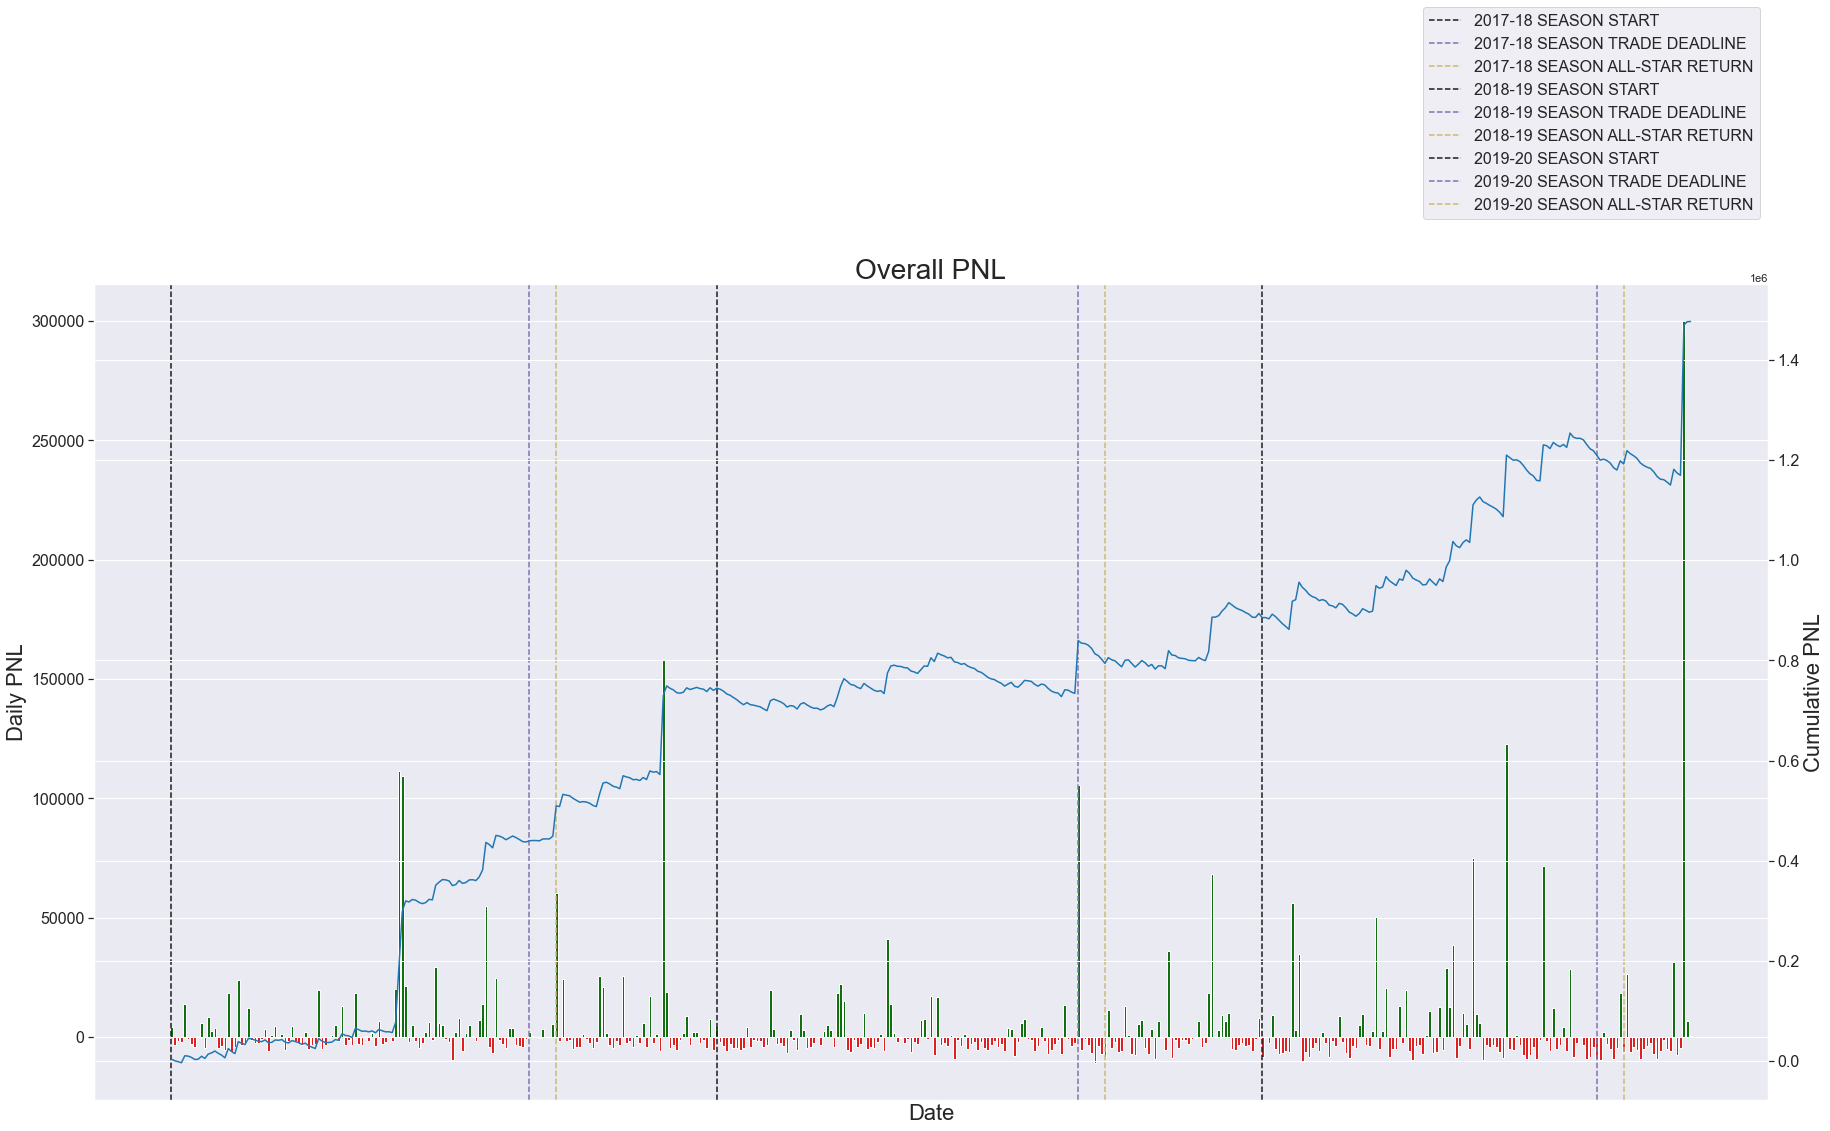

In [6]:
fig = plt.figure(1, figsize=(30, 15))

# overall PNL
temp = results.copy()
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Overall PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, label=xcoords[xcoord][0], color=xcoords[xcoord][1], linestyle='dashed')
ax1.legend(bbox_to_anchor=(1, 1.35), loc='upper right', prop={'size': 16})

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

Break down ROI by contest type, entry fee, and number of games in the slate to determine where my projections generate the most return on investment.


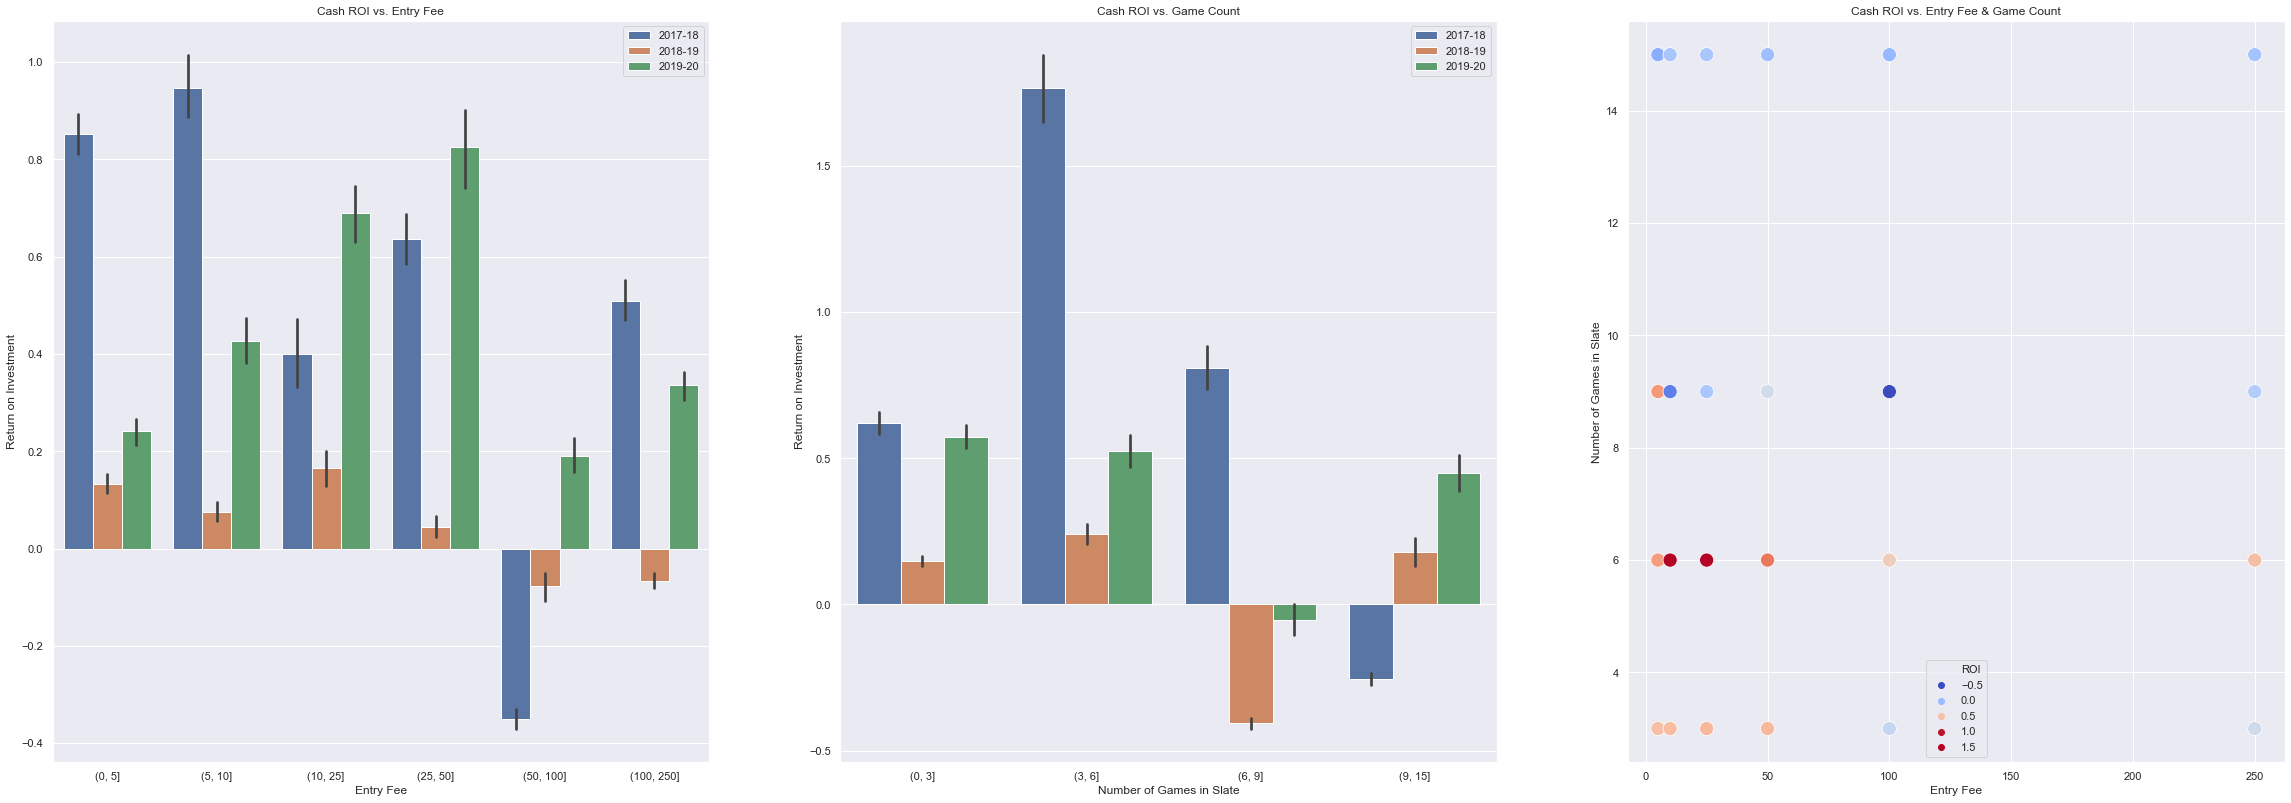

In [7]:
fig = plt.figure(1, figsize=(40, 30))
gs = fig.add_gridspec(2, 3)

# ROI vs. Entry Fee
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(x="ENTRY_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax4)
ax4.set(xlabel="Entry Fee", ylabel="Return on Investment", title="Cash ROI vs. Entry Fee")
ax4.legend()

# ROI vs. Game Count
temp = results.copy()
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax5 = fig.add_subplot(gs[1, 1])
sns.barplot(x="GAME_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax5)
ax5.set(xlabel="Number of Games in Slate", ylabel="Return on Investment", title="Cash ROI vs. Game Count")
ax5.legend()

# ROI vs. Entry Fee & Game Count
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(boxscores[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax6 = fig.add_subplot(gs[1, 2])
pnl['UPPER_ENTRY_FEE'] = pnl['ENTRY_BIN'].apply(lambda x: x.right)
pnl['UPPER_GAME_BIN'] = pnl['GAME_BIN'].apply(lambda x: x.right)
scat = pnl.groupby(['UPPER_GAME_BIN', 'UPPER_ENTRY_FEE']).apply(
    lambda x: pd.Series({
        'ROI': x['ROI'].mean()
    })
).reset_index()
sns.scatterplot(x='UPPER_ENTRY_FEE', y="UPPER_GAME_BIN", data=scat, hue='ROI', s=200, palette='coolwarm', ax=ax6)
ax6.set(xlabel="Entry Fee", ylabel="Number of Games in Slate", title="Cash ROI vs. Entry Fee & Game Count")
ax6.legend()

plt.show()

It is important not to overfit by cherry picking the contests in which the projections made money. To try to avoid this, I bucketed the entry fees and slate game counts. I will also only isolate a subset of contests if it makes sense why they were more profitable. The results above show that virtually no subset of cash games are profitable. On the other hand, tournaments whose entry fees are at most $1000 and slate game counts are at most 6 look profitable. This makes sense: higher entry contests attract more intelligent players, and high game slates introduce more variance.

Below I will graph the cumulative PNL of a strategy that only enters contests in the subset described above. I will also include cash games whose entry fees are at most $25 and slate game counts are at most 3 to verify the lack of edge.

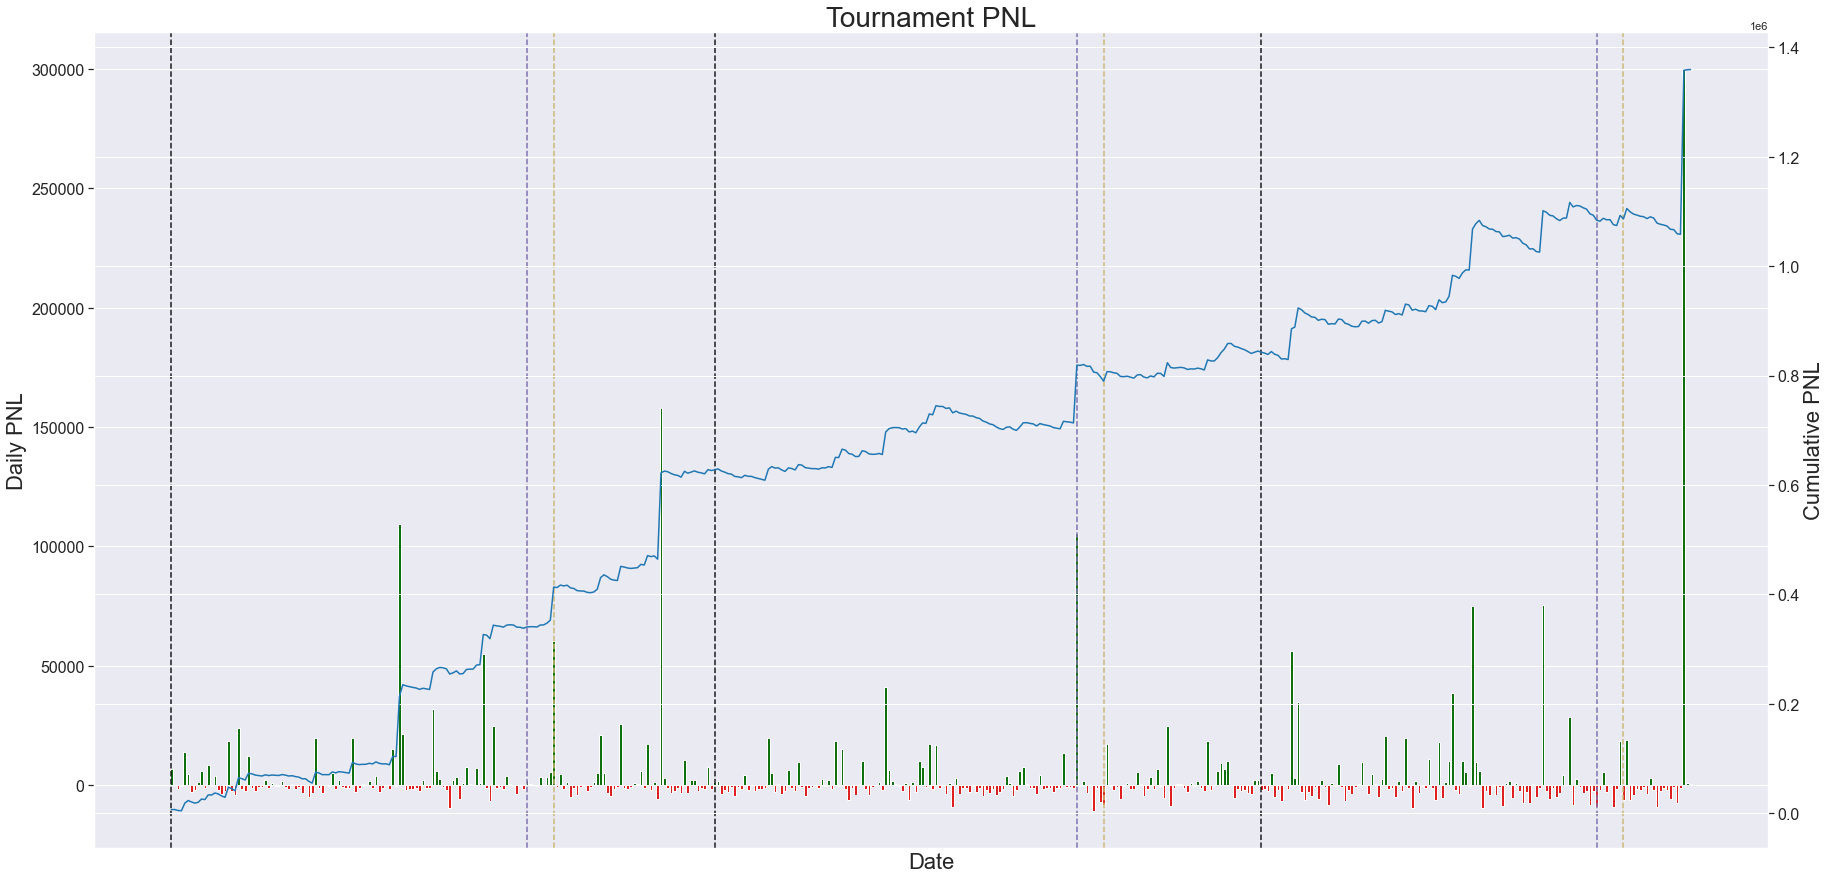

In [8]:
fig, plt.figure(1, figsize=(30, 15))

temp = results.loc[(results['GAME_COUNT'] <= 6)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Tournament PNL', fontsize=28)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, color=xcoords[xcoord][1], linestyle='dashed')

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

I will only focus on tournament contests going forward. The tournament strategy seems like it may actually be profitable. However, there is a lot of variance in PNL, as the cumulative PNL depends entirely on a few days in which it hit big. Most days the strategy loses money, and there are some significant drawdowns.

Below shows the distribution of daily returns of this strategy.

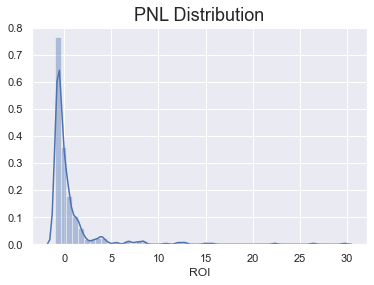

ROI Statistics:


count    454.000000
mean       0.587924
std        3.068753
min       -0.982756
25%       -0.653534
50%       -0.305537
75%        0.485094
max       29.706017
Name: ROI, dtype: float64

In [9]:
temp = results.loc[(results['GAME_COUNT'] <= 6)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['ROI'] = pnl['PNL']/pnl['ENTRY_FEE']
ax = sns.distplot(pnl['ROI'])
ax.set_title('PNL Distribution', fontsize=18)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

print('ROI Statistics:')
pnl['ROI'].describe()

In [10]:
print(pnl['PRIZE'].mean())
print(pnl['ENTRY_FEE'].mean())

7558.0383920704835
4563.361894273128
